In [1]:
import os
import cv2
import glob
import time
import torch
import random
import numpy as np
from copy import deepcopy
from datetime import datetime
import albumentations as augs
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from train import *
from models import *
from datasets import *
from evaluation import *


print('Ready')

Ready


In [2]:
# Data augmentation transforms
geometric_transform=augs.ShiftScaleRotate(scale_limit=0.2, rotate_limit=50, p=0.5,
                                          border_mode=cv2.BORDER_CONSTANT)
content_transform=augs.Compose([augs.Blur(p=0.5),
                                augs.ColorJitter(0.3, 0.3, 0.3, 0,3, p=1.0),
                                augs.ImageCompression(quality_lower=30, p=0.5),
                                augs.CoarseDropout(min_holes=1, max_holes=8,
                                                   min_width=0.03125, min_height=0.03125,
                                                   max_width=0.125, max_height=0.125, p=0.5)])
print('Data augmentation transforms created.')

Data augmentation transforms created.


In [3]:
# Prepare datasets
trainset = LandmarkDataset('./data/300w.tsv', LandmarkDataset.get_partitions('300w', 'train'),
                           geometric_transform=geometric_transform, content_transform=content_transform,
                           random_flip=True)
trainset_small = LandmarkDataset('./data/300w.tsv', LandmarkDataset.get_partitions('300w', 'train'),
                                 geometric_transform=geometric_transform, content_transform=content_transform,
                                 random_flip=True, config=LandmarkDataset.create_config(image_size=128, heatmap_size=32))
trainset_small2 = LandmarkDataset('./data/300w.tsv', LandmarkDataset.get_partitions('300w', 'train'),
                                  geometric_transform=geometric_transform, content_transform=content_transform,
                                  random_flip=True, config=LandmarkDataset.create_config(image_size=128))
trainset_indoor = LandmarkDataset('./data/300w.tsv', [('frgc', ''), ('xm2vts', '')],
                                  geometric_transform=geometric_transform, content_transform=content_transform,
                                  random_flip=True)
trainset_outdoor = LandmarkDataset('./data/300w.tsv', [('afw', ''), ('helen', 'trainset'), ('lfpw', 'trainset')],
                                   geometric_transform=geometric_transform, content_transform=content_transform,
                                   random_flip=True)
print(f"300W training set contains {len(trainset)} examples.")
print(f"300W indoor training set contains {len(trainset_indoor)} examples.")
print(f"300W outdoor training set contains {len(trainset_outdoor)} examples.")
print('')

trainset_lp = LandmarkDataset('./data/300w_lp.tsv', LandmarkDataset.get_partitions('300w_lp', 'train'),
                              geometric_transform=geometric_transform, content_transform=content_transform,
                              random_flip=True)
trainset_lp_small = LandmarkDataset('./data/300w_lp.tsv', LandmarkDataset.get_partitions('300w_lp', 'train'),
                                    geometric_transform=geometric_transform, content_transform=content_transform,
                                    random_flip=True, config=LandmarkDataset.create_config(image_size=128, heatmap_size=32))
trainset_lp_small2 = LandmarkDataset('./data/300w_lp.tsv', LandmarkDataset.get_partitions('300w_lp', 'train'),
                                     geometric_transform=geometric_transform, content_transform=content_transform,
                                     random_flip=True, config=LandmarkDataset.create_config(image_size=128))
trainset_lp_indoor = LandmarkDataset('./data/300w_lp.tsv', [('frgc', ''), ('xm2vts', '')],
                                     geometric_transform=geometric_transform, content_transform=content_transform,
                                     random_flip=True)
trainset_lp_outdoor = LandmarkDataset('./data/300w_lp.tsv',
                                      [('afw', ''), ('helen', 'trainset'), ('lfpw', 'trainset')],
                                      geometric_transform=geometric_transform, content_transform=content_transform,
                                      random_flip=True)
print(f"300W-LP training set contains {len(trainset_lp)} examples.")
print(f"300W-LP indoor training set contains {len(trainset_lp_indoor)} examples.")
print(f"300W-LP outdoor training set contains {len(trainset_lp_outdoor)} examples.")
print('')

valset = LandmarkDataset('./data/300w.tsv', LandmarkDataset.get_partitions('300w', 'val'))
valset_small = LandmarkDataset('./data/300w.tsv', LandmarkDataset.get_partitions('300w', 'val'),
                               config=LandmarkDataset.create_config(image_size=128, heatmap_size=32))
valset_small2 = LandmarkDataset('./data/300w.tsv', LandmarkDataset.get_partitions('300w', 'val'),
                                config=LandmarkDataset.create_config(image_size=128))
valset_lp = LandmarkDataset('./data/300w_lp.tsv', LandmarkDataset.get_partitions('300w_lp', 'val'))
valset_lp_small = LandmarkDataset('./data/300w_lp.tsv', LandmarkDataset.get_partitions('300w_lp', 'val'),
                                  config=LandmarkDataset.create_config(image_size=128, heatmap_size=32))
valset_lp_small2 = LandmarkDataset('./data/300w_lp.tsv', LandmarkDataset.get_partitions('300w_lp', 'val'),
                                   config=LandmarkDataset.create_config(image_size=128))
print(f"300W validations set contains {len(valset)} examples.")
print(f"300W-LP validations set contains {len(valset_lp)} examples.")
print('')

testset_indoor = LandmarkDataset('./data/300w.tsv', [('300W', '01_Indoor')])
testset_indoor_small = LandmarkDataset('./data/300w.tsv', [('300W', '01_Indoor')],
                                       config=LandmarkDataset.create_config(image_size=128, heatmap_size=32))
testset_indoor_small2 = LandmarkDataset('./data/300w.tsv', [('300W', '01_Indoor')],
                                        config=LandmarkDataset.create_config(image_size=128))
testset_outdoor = LandmarkDataset('./data/300w.tsv', [('300W', '02_Outdoor')])
testset_outdoor_small = LandmarkDataset('./data/300w.tsv', [('300W', '02_Outdoor')],
                                        config=LandmarkDataset.create_config(image_size=128, heatmap_size=32))
testset_outdoor_small2 = LandmarkDataset('./data/300w.tsv', [('300W', '02_Outdoor')],
                                         config=LandmarkDataset.create_config(image_size=128))
print(f"300W indoor test set contains {len(testset_indoor)} examples.")
print(f"300W outdoor test set contains {len(testset_outdoor)} examples.")
print('')

testset_lp_indoor = LandmarkDataset('./data/300w_lp.tsv', [('300W', '01_Indoor')])
testset_lp_indoor_small = LandmarkDataset('./data/300w_lp.tsv', [('300W', '01_Indoor')],
                                          config=LandmarkDataset.create_config(image_size=128, heatmap_size=32))
testset_lp_indoor_small2 = LandmarkDataset('./data/300w_lp.tsv', [('300W', '01_Indoor')],
                                           config=LandmarkDataset.create_config(image_size=128))
testset_lp_outdoor = LandmarkDataset('./data/300w_lp.tsv', [('300W', '02_Outdoor')])
testset_lp_outdoor_small = LandmarkDataset('./data/300w_lp.tsv', [('300W', '02_Outdoor')],
                                           config=LandmarkDataset.create_config(image_size=128, heatmap_size=32))
testset_lp_outdoor_small2 = LandmarkDataset('./data/300w_lp.tsv', [('300W', '02_Outdoor')],
                                            config=LandmarkDataset.create_config(image_size=128))
print(f"300W-LP indoor test set contains {len(testset_lp_indoor)} examples.")
print(f"300W-LP outdoor test set contains {len(testset_lp_outdoor)} examples.")

300W training set contains 10458 examples.
300W indoor training set contains 7310 examples.
300W outdoor training set contains 3148 examples.

300W-LP training set contains 180689 examples.
300W-LP indoor training set contains 130364 examples.
300W-LP outdoor training set contains 50325 examples.

300W validations set contains 689 examples.
300W-LP validations set contains 10758 examples.

300W indoor test set contains 300 examples.
300W outdoor test set contains 300 examples.

300W-LP indoor test set contains 4639 examples.
300W-LP outdoor test set contains 4572 examples.


In [4]:
def load_best_snapshot(ckpt_files, metric='val_weighted_macc'):
    best_snapshot = None
    best_ckpt_path = None
    for ckpt_path in tqdm(ckpt_files, desc='Checkpoint'):
        ckpt = torch.load(ckpt_path, map_location='cuda:0')
        if 'best_snapshots' in ckpt:
            for snapshot in ckpt['best_snapshots']:
                if (best_snapshot is None or
                        'loss' in metric and best_snapshot[metric] > snapshot[metric] or
                        'loss' not in metric and best_snapshot[metric] < snapshot[metric]):
                    best_snapshot = snapshot
                    best_ckpt_path = ckpt_path
        del ckpt
        torch.cuda.empty_cache()
    return best_snapshot, best_ckpt_path


def eval_on_300w_n_lp_impl(model, indoor_loader, outdoor_loader, indoor_lp_loader, outdoor_lp_loader, threshold=0.07):
    # Evaluate the model on the test sets
    with tqdm(desc='Test batch (300W indoor)') as pbar:
        test_results_indoor = run_model(model, indoor_loader, pbar=pbar)
    torch.cuda.empty_cache()
    with tqdm(desc='Test batch (300W outdoor)') as pbar:
        test_results_outdoor = run_model(model, outdoor_loader, pbar=pbar)
    torch.cuda.empty_cache()
    
    with tqdm(desc='Test batch (300W-LP indoor)') as pbar:
        test_results_lp_indoor = run_model(model, indoor_lp_loader, pbar=pbar)
    torch.cuda.empty_cache()
    with tqdm(desc='Test batch (300W-LP outdoor)') as pbar:
        test_results_lp_outdoor = run_model(model, outdoor_lp_loader, pbar=pbar)
    torch.cuda.empty_cache()
    
    # Compute AUC
    test_lmk_errors_indoor = compute_landmark_errors(
        test_results_indoor['predicted_landmarks'].mean(axis=1), test_results_indoor['landmarks'])
    test_lmk_bbox_sizes_indoor = get_bbox_sizes(test_results_indoor['landmark_bbox_corners'])[0]
    auc_indoor, errs_indoor, ticks_indoor = compute_auc(
        test_lmk_errors_indoor, threshold, test_lmk_bbox_sizes_indoor)

    test_lmk_errors_outdoor = compute_landmark_errors(
        test_results_outdoor['predicted_landmarks'].mean(axis=1), test_results_outdoor['landmarks'])
    test_lmk_bbox_sizes_outdoor = get_bbox_sizes(test_results_outdoor['landmark_bbox_corners'])[0]
    auc_outdoor, errs_outdoor, ticks_outdoor = compute_auc(
        test_lmk_errors_outdoor, threshold, test_lmk_bbox_sizes_outdoor)
    
    auc, errs, ticks = compute_auc(
        np.concatenate((test_lmk_errors_indoor, test_lmk_errors_outdoor)), threshold,
        np.concatenate((test_lmk_bbox_sizes_indoor, test_lmk_bbox_sizes_outdoor)))
    
    test_lmk_errors_lp_indoor = compute_landmark_errors(
        test_results_lp_indoor['predicted_landmarks'].mean(axis=1), test_results_lp_indoor['landmarks'])
    test_lmk_bbox_sizes_lp_indoor = get_bbox_sizes(test_results_lp_indoor['landmark_bbox_corners'])[0]
    auc_lp_indoor, errs_lp_indoor, ticks_lp_indoor = compute_auc(
        test_lmk_errors_lp_indoor, threshold, test_lmk_bbox_sizes_lp_indoor,
        test_results_lp_indoor['sample_weights'])

    test_lmk_errors_lp_outdoor = compute_landmark_errors(
        test_results_lp_outdoor['predicted_landmarks'].mean(axis=1), test_results_lp_outdoor['landmarks'])
    test_lmk_bbox_sizes_lp_outdoor = get_bbox_sizes(test_results_lp_outdoor['landmark_bbox_corners'])[0]
    auc_lp_outdoor, errs_lp_outdoor, ticks_lp_outdoor = compute_auc(
        test_lmk_errors_lp_outdoor, threshold, test_lmk_bbox_sizes_lp_outdoor,
        test_results_lp_outdoor['sample_weights'])
    
    auc_lp, errs_lp, ticks_lp = compute_auc(
        np.concatenate((test_lmk_errors_lp_indoor, test_lmk_errors_lp_outdoor)), threshold,
        np.concatenate((test_lmk_bbox_sizes_lp_indoor, test_lmk_bbox_sizes_lp_outdoor)),
        np.concatenate((test_results_lp_indoor['sample_weights'], test_results_lp_outdoor['sample_weights'])))

    # Show results
    fig = plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(errs, ticks, label=f"Full testset, AUC@{threshold}={auc:.03f}")
    plt.plot(errs_indoor, ticks_indoor, label=f"Indoor subset, AUC@{threshold}={auc_indoor:.03f}")
    plt.plot(errs_outdoor, ticks_outdoor, label=f"Outdoor subset, AUC@{threshold}={auc_outdoor:.03f}")
    plt.title('CED on 300W (normalised by landmark bounding box size)')
    plt.xlim(0, threshold)
    plt.ylim(0, 1)
    plt.xlabel('Normalised distance error')
    plt.ylabel('Proportion')
    plt.legend()
    plt.grid('both')
    
    plt.subplot(1, 2, 2)
    plt.plot(errs_lp, ticks_lp, label=f"Full testset, AUC@{threshold}={auc_lp:.03f}")
    plt.plot(errs_lp_indoor, ticks_lp_indoor, label=f"Indoor subset, AUC@{threshold}={auc_lp_indoor:.03f}")
    plt.plot(errs_lp_outdoor, ticks_lp_outdoor, label=f"Outdoor subset, AUC@{threshold}={auc_lp_outdoor:.03f}")
    plt.title('CED on 300W-LP (normalised by landmark bounding box size)')
    plt.xlim(0, threshold)
    plt.ylim(0, 1)
    plt.xlabel('Normalised distance error')
    plt.ylabel('Proportion')
    plt.legend()
    plt.grid('both')
    plt.show()


def eval_on_300w_n_lp(model, threshold=0.07):
    return eval_on_300w_n_lp_impl(model, testset_indoor_loader, testset_outdoor_loader,
                                  testset_lp_indoor_loader, testset_lp_outdoor_loader, threshold)


def eval_on_300w_n_lp_small(model, threshold=0.07):
    return eval_on_300w_n_lp_impl(model, testset_indoor_small_loader, testset_outdoor_small_loader,
                                  testset_lp_indoor_small_loader, testset_lp_outdoor_small_loader, threshold)


def eval_on_300w_n_lp_small2(model, threshold=0.07):
    return eval_on_300w_n_lp_impl(model, testset_indoor_small2_loader, testset_outdoor_small2_loader,
                                  testset_lp_indoor_small2_loader, testset_lp_outdoor_small2_loader, threshold)


testset_indoor_loader = DataLoader(testset_indoor, batch_size=16, shuffle=False, num_workers=32, pin_memory=True)
testset_indoor_small_loader = DataLoader(testset_indoor_small, batch_size=16,
                                         shuffle=False, num_workers=32, pin_memory=True)
testset_indoor_small2_loader = DataLoader(testset_indoor_small2, batch_size=16,
                                          shuffle=False, num_workers=32, pin_memory=True)
testset_outdoor_loader = DataLoader(testset_outdoor, batch_size=16, shuffle=False, num_workers=32, pin_memory=True)
testset_outdoor_small_loader = DataLoader(testset_outdoor_small, batch_size=16,
                                          shuffle=False, num_workers=32, pin_memory=True)
testset_outdoor_small2_loader = DataLoader(testset_outdoor_small2, batch_size=16,
                                           shuffle=False, num_workers=32, pin_memory=True)
print('300W test data loaders created.')

testset_lp_indoor_loader = DataLoader(testset_lp_indoor, batch_size=16,
                                      shuffle=False, num_workers=32, pin_memory=True)
testset_lp_indoor_small_loader = DataLoader(testset_lp_indoor_small, batch_size=16,
                                            shuffle=False, num_workers=32, pin_memory=True)
testset_lp_indoor_small2_loader = DataLoader(testset_lp_indoor_small2, batch_size=16,
                                             shuffle=False, num_workers=32, pin_memory=True)
testset_lp_outdoor_loader = DataLoader(testset_lp_outdoor, batch_size=16,
                                       shuffle=False, num_workers=32, pin_memory=True)
testset_lp_outdoor_small_loader = DataLoader(testset_lp_outdoor_small, batch_size=16,
                                             shuffle=False, num_workers=32, pin_memory=True)
testset_lp_outdoor_small2_loader = DataLoader(testset_lp_outdoor_small2, batch_size=16,
                                              shuffle=False, num_workers=32, pin_memory=True)
print('300W-LP test data loaders created.')

300W test data loaders created.
300W-LP test data loaders created.


## Experiment 0.1: Test the pretrained 4-hourglass model on 300W and 300W-LP

Test batch (300W indoor): 0it [00:00, ?it/s]

Test batch (300W outdoor): 0it [00:00, ?it/s]

Test batch (300W-LP indoor): 0it [00:00, ?it/s]

Test batch (300W-LP outdoor): 0it [00:00, ?it/s]

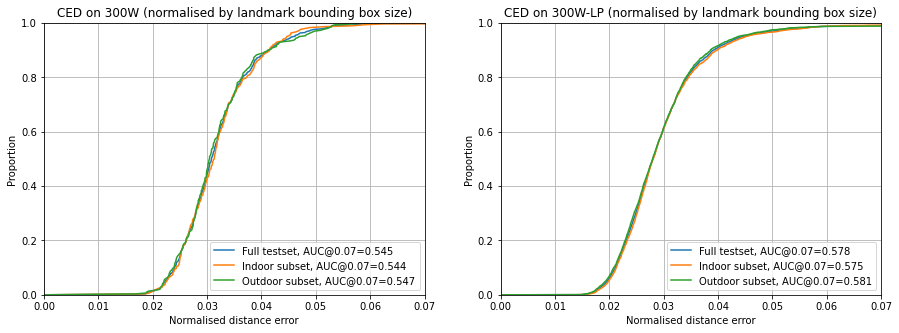

In [5]:
fan = FAN(FAN.create_config(num_modules=4, use_avg_pool=True)).cuda()
fan.load_state_dict(torch.load('./pretrained/2dfan4.pth', map_location='cuda:0'))
eval_on_300w_n_lp(fan)
del fan
torch.cuda.empty_cache()

## Experiment 0.2: Test the pretrained 2-hourglass model on 300W

Test batch (300W indoor): 0it [00:00, ?it/s]

Test batch (300W outdoor): 0it [00:00, ?it/s]

Test batch (300W-LP indoor): 0it [00:00, ?it/s]

Test batch (300W-LP outdoor): 0it [00:00, ?it/s]

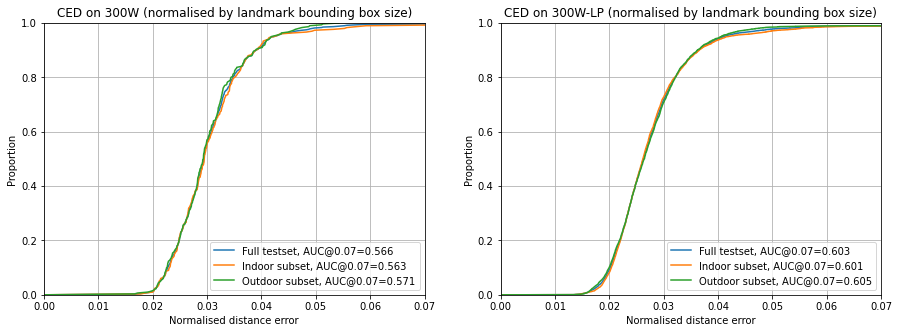

In [6]:
fan = FAN(FAN.create_config(num_modules=2, use_avg_pool=False)).cuda()
fan.load_state_dict(torch.load('./pretrained/2dfan2.pth', map_location='cuda:0'))
eval_on_300w_n_lp(fan)
del fan
torch.cuda.empty_cache()

## Experiment 1.1: Train FAN2 on 300W for 10 epochs
This is just to make sure that everything works.

In [5]:
# Create data loaders
trainset_loader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=32, pin_memory=True)
valset_loader = DataLoader(valset, batch_size=16, shuffle=False, num_workers=32, pin_memory=True)
print('Data loaders created.')

# Create the model
fan = FAN(FAN.create_config(num_modules=2, use_avg_pool=False))
fan = torch.nn.DataParallel(fan).cuda()
print('Network initialised.')

# Create the optimiser
optimiser = torch.optim.RMSprop(fan.parameters(), lr=5e-4, momentum=0.9, weight_decay=0.0)
print('Optimiser created.')

# Create the learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=8, gamma=0.7)
print('LR scheduler created.')

# Train the network
torch.cuda.empty_cache()
with tqdm(desc='Epoch') as pbar1, tqdm(desc='Train batch') as pbar2, tqdm(desc='Validation batch') as pbar3:
    exp_01_01_ckpt_path = train_model(
        fan, optimiser, trainset_loader, valset_loader, 10, './logs', './checkpoints',
        f"exp_01_01_fan2_300w_{datetime.utcnow().strftime('%Y-%m-%d_%H-%M-%S.%f')[:-3]}_utc",
        lr_scheduler=lr_scheduler, val_per_epoch=2, save_top_k=5,
        htm_mse_loss_weight=1.0, lmk_dist_loss_weight=0.01, rank_by='val_weighted_macc',
        train_weight_norm=trainset_loader.dataset.weight_norm,
        pbar_epochs=pbar1, pbar_train_batches=pbar2, pbar_val_batches=pbar3)
del lr_scheduler
del optimiser
del fan
torch.cuda.empty_cache()
print(f"Training finished, checkpoint saved to: {exp_01_01_ckpt_path}")

Data loaders created.


/home/hhj/anaconda3/envs/py37misc/lib/python3.7/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


Network initialised.
Optimiser created.
LR scheduler created.


Epoch: 0it [00:00, ?it/s]

Train batch: 0it [00:00, ?it/s]

Validation batch: 0it [00:00, ?it/s]

Training finished, checkpoint saved to: ./checkpoints/exp_01_01_fan2_300w_2021-11-06_22-43-49.448_utc.ckpt


Checkpoint:   0%|          | 0/4 [00:00<?, ?it/s]

Best weights loaded from ./checkpoints/exp_01_01_fan2_300w_2021-10-25_00-45-06.388_utc.ckpt at epoch #9.502


Test batch (300W indoor): 0it [00:00, ?it/s]

Test batch (300W outdoor): 0it [00:00, ?it/s]

Test batch (300W-LP indoor): 0it [00:00, ?it/s]

Test batch (300W-LP outdoor): 0it [00:00, ?it/s]

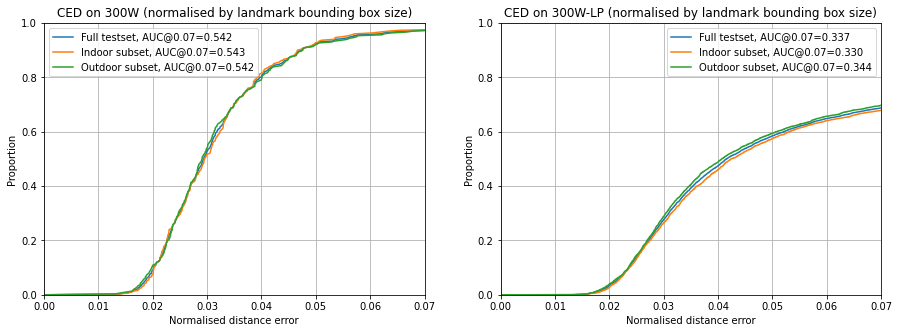

In [5]:
best_snapshot, best_ckpt_path = load_best_snapshot(
    sorted(glob.glob(os.path.join('./checkpoints', 'exp_01_01_*')))[::-1])
print(f"Best weights loaded from {best_ckpt_path} at epoch #{best_snapshot['epoch']:.3f}")

fan = FAN(FAN.create_config(num_modules=2, use_avg_pool=False)).to('cuda:0')
fan.load_state_dict(best_snapshot['model_state_dict'])
del best_snapshot
torch.cuda.empty_cache()

eval_on_300w_n_lp(fan)
del fan
torch.cuda.empty_cache()

## Experiment 1.2: Train FAN2 on 300W-LP for 25 epochs
This is a preliminary test, just to see what performance we may expect from 300W-LP.

In [5]:
# Create data loaders
trainset_loader = DataLoader(trainset_lp, batch_size=32, shuffle=True, num_workers=32, pin_memory=True)
valset_loader = DataLoader(valset_lp, batch_size=16, shuffle=False, num_workers=32, pin_memory=True)
print('Data loaders created.')

# Create the model
fan = FAN(FAN.create_config(num_modules=2, use_avg_pool=False))
fan = torch.nn.DataParallel(fan).cuda()
print('Network initialised.')

# Create the optimiser
optimiser = torch.optim.RMSprop(fan.parameters(), lr=5e-4, momentum=0.9, weight_decay=0.0)
print('Optimiser created.')

# Create the learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=3, gamma=0.7)
print('LR scheduler created.')

# Train the network
torch.cuda.empty_cache()
with tqdm(desc='Epoch') as pbar1, tqdm(desc='Train batch') as pbar2, tqdm(desc='Validation batch') as pbar3:
    exp_01_02_ckpt_path = train_model(
        fan, optimiser, trainset_loader, valset_loader, 25, './logs', './checkpoints',
        f"exp_01_02_fan2_300w_lp_{datetime.utcnow().strftime('%Y-%m-%d_%H-%M-%S.%f')[:-3]}_utc",
        lr_scheduler=lr_scheduler, val_per_epoch=5, save_top_k=10,
        htm_mse_loss_weight=1.0, lmk_dist_loss_weight=0.01, rank_by='val_weighted_macc',
        train_weight_norm=trainset_loader.dataset.weight_norm,
        pbar_epochs=pbar1, pbar_train_batches=pbar2, pbar_val_batches=pbar3)
del lr_scheduler
del optimiser
del fan
torch.cuda.empty_cache()
print(f"Training finished, checkpoint saved to: {exp_01_02_ckpt_path}")

Data loaders created.


/home/hhj/anaconda3/envs/py37misc/lib/python3.7/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


Network initialised.
Optimiser created.
LR scheduler created.


Epoch: 0it [00:00, ?it/s]

Train batch: 0it [00:00, ?it/s]

Validation batch: 0it [00:00, ?it/s]

Training finished, checkpoint saved to: ./checkpoints/exp_01_02_fan2_300w_lp_2021-10-25_11-46-27.463_utc.ckpt


Checkpoint:   0%|          | 0/4 [00:00<?, ?it/s]

Best weights loaded from ./checkpoints/exp_01_02_fan2_300w_lp_2021-10-25_11-46-27.463_utc.ckpt at epoch #24.800


Test batch (300W indoor): 0it [00:00, ?it/s]

Test batch (300W outdoor): 0it [00:00, ?it/s]

Test batch (300W-LP indoor): 0it [00:00, ?it/s]

Test batch (300W-LP outdoor): 0it [00:00, ?it/s]

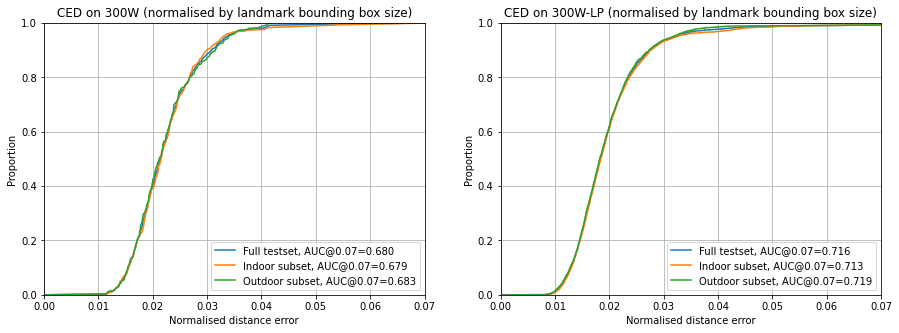

In [6]:
best_snapshot, best_ckpt_path = load_best_snapshot(
    sorted(glob.glob(os.path.join('./checkpoints', 'exp_01_02_*')))[::-1])
print(f"Best weights loaded from {best_ckpt_path} at epoch #{best_snapshot['epoch']:.3f}")

fan = FAN(FAN.create_config(num_modules=2, use_avg_pool=False)).to('cuda:0')
fan.load_state_dict(best_snapshot['model_state_dict'])
del best_snapshot
torch.cuda.empty_cache()

eval_on_300w_n_lp(fan)
del fan
torch.cuda.empty_cache()

## Experiment 2.1: Train FAN2 on 300W for 60 epochs

In [6]:
# Create data loaders
trainset_loader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=32, pin_memory=True)
valset_loader = DataLoader(valset, batch_size=16, shuffle=False, num_workers=32, pin_memory=True)
print('Data loaders created.')

# Create the model
fan = FAN(FAN.create_config(num_modules=2, use_avg_pool=False))
fan = torch.nn.DataParallel(fan).cuda()
print('Network initialised.')

# Create the optimiser
optimiser = torch.optim.RMSprop(fan.parameters(), lr=5e-4, momentum=0.9, weight_decay=0.0)
print('Optimiser created.')

# Create the learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=8, gamma=0.7)
print('LR scheduler created.')

# Train the network
torch.cuda.empty_cache()
with tqdm(desc='Epoch') as pbar1, tqdm(desc='Train batch') as pbar2, tqdm(desc='Validation batch') as pbar3:
    exp_02_01_ckpt_path = train_model(
        fan, optimiser, trainset_loader, valset_loader, 60, './logs', './checkpoints',
        f"exp_02_01_fan2_300w_{datetime.utcnow().strftime('%Y-%m-%d_%H-%M-%S.%f')[:-3]}_utc",
        lr_scheduler=lr_scheduler, val_per_epoch=2, save_top_k=10,
        htm_mse_loss_weight=1.0, lmk_dist_loss_weight=0.01, rank_by='val_weighted_macc',
        train_weight_norm=trainset_loader.dataset.weight_norm,
        pbar_epochs=pbar1, pbar_train_batches=pbar2, pbar_val_batches=pbar3)
del lr_scheduler
del optimiser
del fan
torch.cuda.empty_cache()
print(f"Training finished, checkpoint saved to: {exp_02_01_ckpt_path}")

Data loaders created.


/home/hhj/anaconda3/envs/py37misc/lib/python3.7/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


Network initialised.
Optimiser created.
LR scheduler created.


Epoch: 0it [00:00, ?it/s]

Train batch: 0it [00:00, ?it/s]

Validation batch: 0it [00:00, ?it/s]

Training finished, checkpoint saved to: ./checkpoints/exp_02_01_fan2_300w_2021-10-26_19-35-38.839_utc.ckpt


Checkpoint:   0%|          | 0/4 [00:00<?, ?it/s]

Best weights loaded from ./checkpoints/exp_02_01_fan2_300w_2021-10-25_08-58-18.592_utc.ckpt at epoch #48.000


Test batch (300W indoor): 0it [00:00, ?it/s]

Test batch (300W outdoor): 0it [00:00, ?it/s]

Test batch (300W-LP indoor): 0it [00:00, ?it/s]

Test batch (300W-LP outdoor): 0it [00:00, ?it/s]

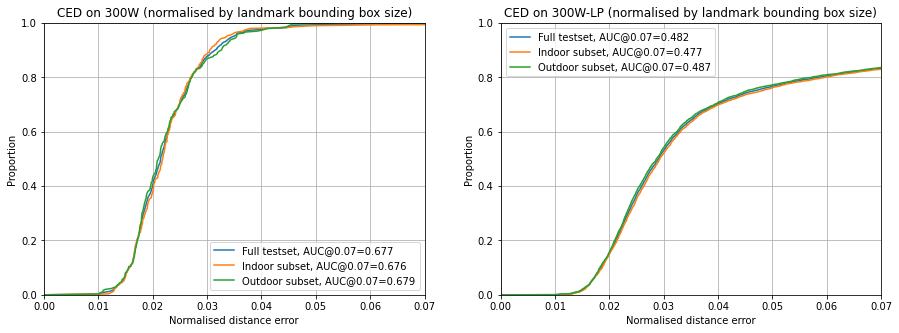

In [7]:
best_snapshot, best_ckpt_path = load_best_snapshot(
    sorted(glob.glob(os.path.join('./checkpoints', 'exp_02_01_*')))[::-1])
print(f"Best weights loaded from {best_ckpt_path} at epoch #{best_snapshot['epoch']:.3f}")

fan = FAN(FAN.create_config(num_modules=2, use_avg_pool=False)).to('cuda:0')
fan.load_state_dict(best_snapshot['model_state_dict'])
del best_snapshot
torch.cuda.empty_cache()

eval_on_300w_n_lp(fan)
del fan
torch.cuda.empty_cache()

## Experiment 2.2: Train FAN2 on the indoor subset of 300W for 90 epochs
This is to see the influence of indoor vs. outdoor data

In [5]:
# Create data loaders
trainset_loader = DataLoader(trainset_indoor, batch_size=32, shuffle=True, num_workers=32, pin_memory=True)
valset_loader = DataLoader(valset, batch_size=16, shuffle=False, num_workers=32, pin_memory=True)
print('Data loaders created.')

# Create the model
fan = FAN(FAN.create_config(num_modules=2, use_avg_pool=False))
fan = torch.nn.DataParallel(fan).cuda()
print('Network initialised.')

# Create the optimiser
optimiser = torch.optim.RMSprop(fan.parameters(), lr=5e-4, momentum=0.9, weight_decay=0.0)
print('Optimiser created.')

# Create the learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=12, gamma=0.7)
print('LR scheduler created.')

# Train the network
torch.cuda.empty_cache()
with tqdm(desc='Epoch') as pbar1, tqdm(desc='Train batch') as pbar2, tqdm(desc='Validation batch') as pbar3:
    exp_02_02_ckpt_path = train_model(
        fan, optimiser, trainset_loader, valset_loader, 90, './logs', './checkpoints',
        f"exp_02_02_fan2_300w_indoor_{datetime.utcnow().strftime('%Y-%m-%d_%H-%M-%S.%f')[:-3]}_utc",
        lr_scheduler=lr_scheduler, val_per_epoch=1, save_top_k=10,
        htm_mse_loss_weight=1.0, lmk_dist_loss_weight=0.01, rank_by='val_weighted_macc',
        train_weight_norm=trainset_loader.dataset.weight_norm,
        pbar_epochs=pbar1, pbar_train_batches=pbar2, pbar_val_batches=pbar3)
del lr_scheduler
del optimiser
del fan
torch.cuda.empty_cache()
print(f"Training finished, checkpoint saved to: {exp_02_02_ckpt_path}")

Data loaders created.


/home/hhj/anaconda3/envs/py37misc/lib/python3.7/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


Network initialised.
Optimiser created.
LR scheduler created.


Epoch: 0it [00:00, ?it/s]

Train batch: 0it [00:00, ?it/s]

Validation batch: 0it [00:00, ?it/s]

Training finished, checkpoint saved to: ./checkpoints/exp_02_02_fan2_300w_indoor_2021-10-26_22-00-10.141_utc.ckpt


Checkpoint:   0%|          | 0/6 [00:00<?, ?it/s]

Best weights loaded from ./checkpoints/exp_02_02_fan2_300w_indoor_2021-10-26_16-27-13.486_utc.ckpt at epoch #56.000


Test batch (300W indoor): 0it [00:00, ?it/s]

Test batch (300W outdoor): 0it [00:00, ?it/s]

Test batch (300W-LP indoor): 0it [00:00, ?it/s]

Test batch (300W-LP outdoor): 0it [00:00, ?it/s]

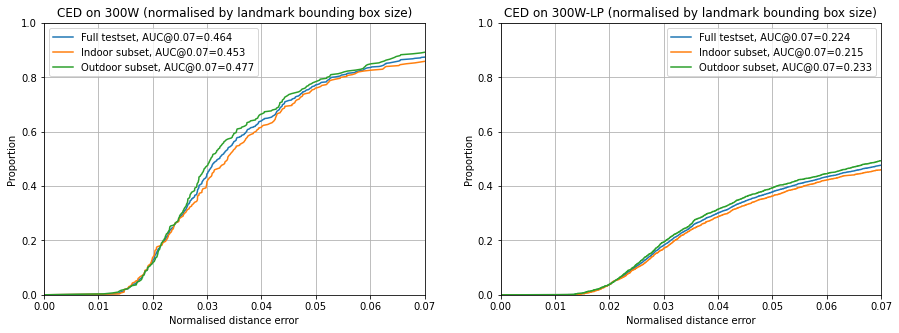

In [8]:
best_snapshot, best_ckpt_path = load_best_snapshot(
    sorted(glob.glob(os.path.join('./checkpoints', 'exp_02_02_*')))[::-1])
print(f"Best weights loaded from {best_ckpt_path} at epoch #{best_snapshot['epoch']:.3f}")

fan = FAN(FAN.create_config(num_modules=2, use_avg_pool=False)).to('cuda:0')
fan.load_state_dict(best_snapshot['model_state_dict'])
del best_snapshot
torch.cuda.empty_cache()

eval_on_300w_n_lp(fan)
del fan
torch.cuda.empty_cache()

## Experiment 2.3: Train FAN2 on the outdoor subset of 300W for 180 epochs
This is to see the influence of indoor vs. outdoor data

In [5]:
# Create data loaders
trainset_loader = DataLoader(trainset_outdoor, batch_size=32, shuffle=True, num_workers=32, pin_memory=True)
valset_loader = DataLoader(valset, batch_size=16, shuffle=False, num_workers=32, pin_memory=True)
print('Data loaders created.')

# Create the model
fan = FAN(FAN.create_config(num_modules=2, use_avg_pool=False))
fan = torch.nn.DataParallel(fan).cuda()
print('Network initialised.')

# Create the optimiser
optimiser = torch.optim.RMSprop(fan.parameters(), lr=5e-4, momentum=0.9, weight_decay=0.0)
print('Optimiser created.')

# Create the learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=24, gamma=0.7)
print('LR scheduler created.')

# Train the network
torch.cuda.empty_cache()
with tqdm(desc='Epoch') as pbar1, tqdm(desc='Train batch') as pbar2, tqdm(desc='Validation batch') as pbar3:
    exp_02_03_ckpt_path = train_model(
        fan, optimiser, trainset_loader, valset_loader, 180, './logs', './checkpoints',
        f"exp_02_03_fan2_300w_outdoor_{datetime.utcnow().strftime('%Y-%m-%d_%H-%M-%S.%f')[:-3]}_utc",
        lr_scheduler=lr_scheduler, val_per_epoch=1, save_top_k=10,
        htm_mse_loss_weight=1.0, lmk_dist_loss_weight=0.01, rank_by='val_weighted_macc',
        train_weight_norm=trainset_loader.dataset.weight_norm,
        pbar_epochs=pbar1, pbar_train_batches=pbar2, pbar_val_batches=pbar3)
del lr_scheduler
del optimiser
del fan
torch.cuda.empty_cache()
print(f"Training finished, checkpoint saved to: {exp_02_03_ckpt_path}")

Data loaders created.


/home/hhj/anaconda3/envs/py37misc/lib/python3.7/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


Network initialised.
Optimiser created.
LR scheduler created.


Epoch: 0it [00:00, ?it/s]

Train batch: 0it [00:00, ?it/s]

Validation batch: 0it [00:00, ?it/s]

Training finished, checkpoint saved to: ./checkpoints/exp_02_03_fan2_300w_outdoor_2021-10-26_10-13-38.408_utc.ckpt


Checkpoint:   0%|          | 0/2 [00:00<?, ?it/s]

Best weights loaded from ./checkpoints/exp_02_03_fan2_300w_outdoor_2021-10-26_10-13-38.408_utc.ckpt at epoch #157.000


Test batch (300W indoor): 0it [00:00, ?it/s]

Test batch (300W outdoor): 0it [00:00, ?it/s]

Test batch (300W-LP indoor): 0it [00:00, ?it/s]

Test batch (300W-LP outdoor): 0it [00:00, ?it/s]

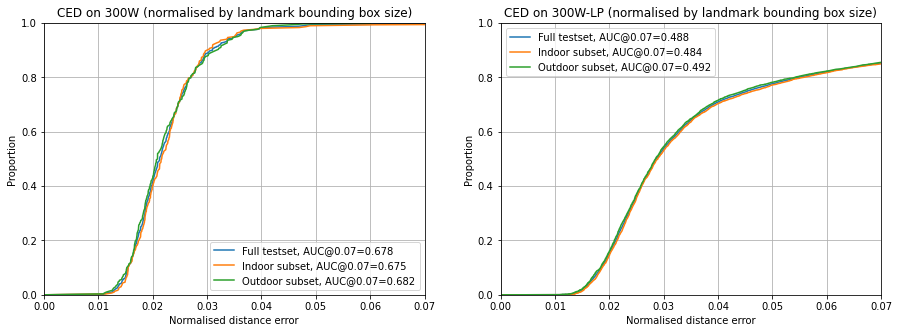

In [9]:
best_snapshot, best_ckpt_path = load_best_snapshot(
    sorted(glob.glob(os.path.join('./checkpoints', 'exp_02_03_*')))[::-1])
print(f"Best weights loaded from {best_ckpt_path} at epoch #{best_snapshot['epoch']:.3f}")

fan = FAN(FAN.create_config(num_modules=2, use_avg_pool=False)).to('cuda:0')
fan.load_state_dict(best_snapshot['model_state_dict'])
del best_snapshot
torch.cuda.empty_cache()

eval_on_300w_n_lp(fan)
del fan
torch.cuda.empty_cache()

## Experiment 3.1: Train FAN2 on 300W for 60 epochs with only MSE loss

In [5]:
# Create data loaders
trainset_loader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=32, pin_memory=True)
valset_loader = DataLoader(valset, batch_size=16, shuffle=False, num_workers=32, pin_memory=True)
print('Data loaders created.')

# Create the model
fan = FAN(FAN.create_config(num_modules=2, use_avg_pool=False))
fan = torch.nn.DataParallel(fan).cuda()
print('Network initialised.')

# Create the optimiser
optimiser = torch.optim.RMSprop(fan.parameters(), lr=5e-4, momentum=0.9, weight_decay=0.0)
print('Optimiser created.')

# Create the learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=8, gamma=0.7)
print('LR scheduler created.')

# Train the network
torch.cuda.empty_cache()
with tqdm(desc='Epoch') as pbar1, tqdm(desc='Train batch') as pbar2, tqdm(desc='Validation batch') as pbar3:
    exp_03_01_ckpt_path = train_model(
        fan, optimiser, trainset_loader, valset_loader, 60, './logs', './checkpoints',
        f"exp_03_01_fan2_300w_{datetime.utcnow().strftime('%Y-%m-%d_%H-%M-%S.%f')[:-3]}_utc",
        lr_scheduler=lr_scheduler, val_per_epoch=2, save_top_k=10,
        htm_mse_loss_weight=1.0, lmk_dist_loss_weight=0.0, rank_by='val_weighted_macc',
        train_weight_norm=trainset_loader.dataset.weight_norm,
        pbar_epochs=pbar1, pbar_train_batches=pbar2, pbar_val_batches=pbar3)
del lr_scheduler
del optimiser
del fan
torch.cuda.empty_cache()
print(f"Training finished, checkpoint saved to: {exp_03_01_ckpt_path}")

Data loaders created.


/home/hhj/anaconda3/envs/py37misc/lib/python3.7/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


Network initialised.
Optimiser created.
LR scheduler created.


Epoch: 0it [00:00, ?it/s]

Train batch: 0it [00:00, ?it/s]

Validation batch: 0it [00:00, ?it/s]

Training finished, checkpoint saved to: ./checkpoints/exp_03_01_fan2_300w_2021-10-27_10-28-00.231_utc.ckpt


Checkpoint:   0%|          | 0/1 [00:00<?, ?it/s]

Best weights loaded from ./checkpoints/exp_03_01_fan2_300w_2021-10-27_10-28-00.231_utc.ckpt at epoch #59.502


Test batch (300W indoor): 0it [00:00, ?it/s]

Test batch (300W outdoor): 0it [00:00, ?it/s]

Test batch (300W-LP indoor): 0it [00:00, ?it/s]

Test batch (300W-LP outdoor): 0it [00:00, ?it/s]

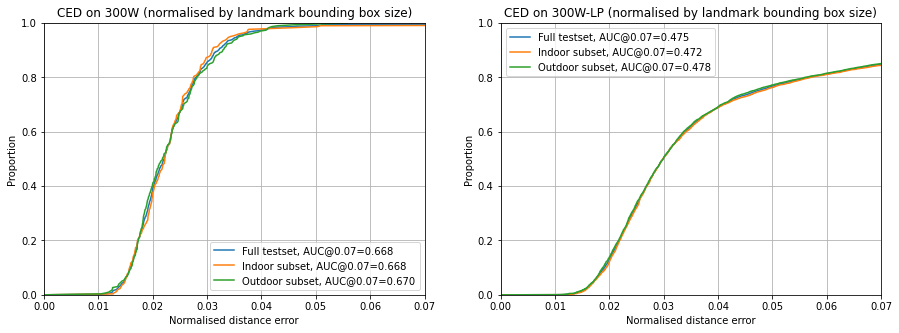

In [10]:
best_snapshot, best_ckpt_path = load_best_snapshot(
    sorted(glob.glob(os.path.join('./checkpoints', 'exp_03_01_*')))[::-1])
print(f"Best weights loaded from {best_ckpt_path} at epoch #{best_snapshot['epoch']:.3f}")

fan = FAN(FAN.create_config(num_modules=2, use_avg_pool=False)).to('cuda:0')
fan.load_state_dict(best_snapshot['model_state_dict'])
del best_snapshot
torch.cuda.empty_cache()

eval_on_300w_n_lp(fan)
del fan
torch.cuda.empty_cache()

## Experiment 3.2: Train FAN2 on 300W for 60 epochs with only MSE loss and without subpixel Gaussian sampling

In [7]:
# Create data loaders
trainset_old = deepcopy(trainset)
trainset_old.config.heatmap_with_subpixel_sampling = False
trainset_loader = DataLoader(trainset_old, batch_size=32, shuffle=True, num_workers=32, pin_memory=True)
valset_loader = DataLoader(valset, batch_size=16, shuffle=False, num_workers=32, pin_memory=True)
print('Data loaders created.')

# Create the model
fan = FAN(FAN.create_config(num_modules=2, use_avg_pool=False))
fan = torch.nn.DataParallel(fan).cuda()
print('Network initialised.')

# Create the optimiser
optimiser = torch.optim.RMSprop(fan.parameters(), lr=5e-4, momentum=0.9, weight_decay=0.0)
print('Optimiser created.')

# Create the learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=8, gamma=0.7)
print('LR scheduler created.')

# Train the network
torch.cuda.empty_cache()
with tqdm(desc='Epoch') as pbar1, tqdm(desc='Train batch') as pbar2, tqdm(desc='Validation batch') as pbar3:
    exp_03_02_ckpt_path = train_model(
        fan, optimiser, trainset_loader, valset_loader, 60, './logs', './checkpoints',
        f"exp_03_02_fan2_300w_{datetime.utcnow().strftime('%Y-%m-%d_%H-%M-%S.%f')[:-3]}_utc",
        lr_scheduler=lr_scheduler, val_per_epoch=2, save_top_k=10,
        htm_mse_loss_weight=1.0, lmk_dist_loss_weight=0.0, rank_by='val_weighted_macc',
        train_weight_norm=trainset_loader.dataset.weight_norm,
        pbar_epochs=pbar1, pbar_train_batches=pbar2, pbar_val_batches=pbar3)
del lr_scheduler
del optimiser
del fan
torch.cuda.empty_cache()
print(f"Training finished, checkpoint saved to: {exp_03_02_ckpt_path}")

Data loaders created.
Network initialised.
Optimiser created.
LR scheduler created.


/home/hhj/anaconda3/envs/py37misc/lib/python3.7/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


Checkpoint:   0%|          | 0/2 [00:00<?, ?it/s]

Best weights loaded from ./checkpoints/exp_03_02_fan2_300w_2021-10-27_13-50-14.243_utc.ckpt at epoch #46.000


Test batch (300W indoor): 0it [00:00, ?it/s]

Test batch (300W outdoor): 0it [00:00, ?it/s]

Test batch (300W-LP indoor): 0it [00:00, ?it/s]

Test batch (300W-LP outdoor): 0it [00:00, ?it/s]

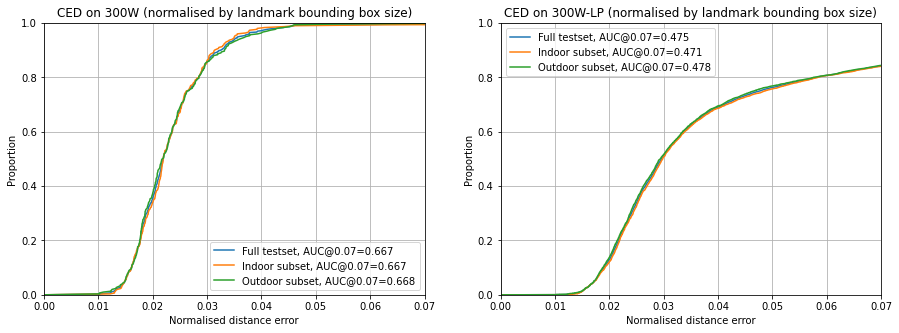

In [11]:
best_snapshot, best_ckpt_path = load_best_snapshot(
    sorted(glob.glob(os.path.join('./checkpoints', 'exp_03_02_*')))[::-1])
print(f"Best weights loaded from {best_ckpt_path} at epoch #{best_snapshot['epoch']:.3f}")

fan = FAN(FAN.create_config(num_modules=2, use_avg_pool=False)).to('cuda:0')
fan.load_state_dict(best_snapshot['model_state_dict'])
del best_snapshot
torch.cuda.empty_cache()

eval_on_300w_n_lp(fan)
del fan
torch.cuda.empty_cache()

## Experiment 3.3: Train FAN2 on 300W for 60 epochs with only MSE loss, without subpixel Gaussian sampling, and using the old preprocessing method

In [6]:
# Create data loaders
trainset_old = deepcopy(trainset)
trainset_old.config.use_improved_preprocessing = False
trainset_old.config.heatmap_with_subpixel_sampling = False
trainset_loader = DataLoader(trainset_old, batch_size=32, shuffle=True, num_workers=32, pin_memory=True)
valset_loader = DataLoader(valset, batch_size=16, shuffle=False, num_workers=32, pin_memory=True)
print('Data loaders created.')

# Create the model
fan = FAN(FAN.create_config(num_modules=2, use_avg_pool=False))
fan = torch.nn.DataParallel(fan).cuda()
print('Network initialised.')

# Create the optimiser
optimiser = torch.optim.RMSprop(fan.parameters(), lr=5e-4, momentum=0.9, weight_decay=0.0)
print('Optimiser created.')

# Create the learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=8, gamma=0.7)
print('LR scheduler created.')

# Train the network
torch.cuda.empty_cache()
with tqdm(desc='Epoch') as pbar1, tqdm(desc='Train batch') as pbar2, tqdm(desc='Validation batch') as pbar3:
    exp_03_03_ckpt_path = train_model(
        fan, optimiser, trainset_loader, valset_loader, 60, './logs', './checkpoints',
        f"exp_03_03_fan2_300w_{datetime.utcnow().strftime('%Y-%m-%d_%H-%M-%S.%f')[:-3]}_utc",
        lr_scheduler=lr_scheduler, val_per_epoch=2, save_top_k=10,
        htm_mse_loss_weight=1.0, lmk_dist_loss_weight=0.0, rank_by='val_weighted_macc',
        train_weight_norm=trainset_loader.dataset.weight_norm,
        pbar_epochs=pbar1, pbar_train_batches=pbar2, pbar_val_batches=pbar3)
del lr_scheduler
del optimiser
del fan
torch.cuda.empty_cache()
print(f"Training finished, checkpoint saved to: {exp_03_03_ckpt_path}")

Data loaders created.


/home/hhj/anaconda3/envs/py37misc/lib/python3.7/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


Network initialised.
Optimiser created.
LR scheduler created.


Epoch: 0it [00:00, ?it/s]

Train batch: 0it [00:00, ?it/s]

Validation batch: 0it [00:00, ?it/s]

Training finished, checkpoint saved to: ./checkpoints/exp_03_03_fan2_300w_2021-10-27_17-17-34.010_utc.ckpt


Checkpoint:   0%|          | 0/1 [00:00<?, ?it/s]

Best weights loaded from ./checkpoints/exp_03_03_fan2_300w_2021-10-27_17-17-34.010_utc.ckpt at epoch #49.000


Test batch (300W indoor): 0it [00:00, ?it/s]

Test batch (300W outdoor): 0it [00:00, ?it/s]

Test batch (300W-LP indoor): 0it [00:00, ?it/s]

Test batch (300W-LP outdoor): 0it [00:00, ?it/s]

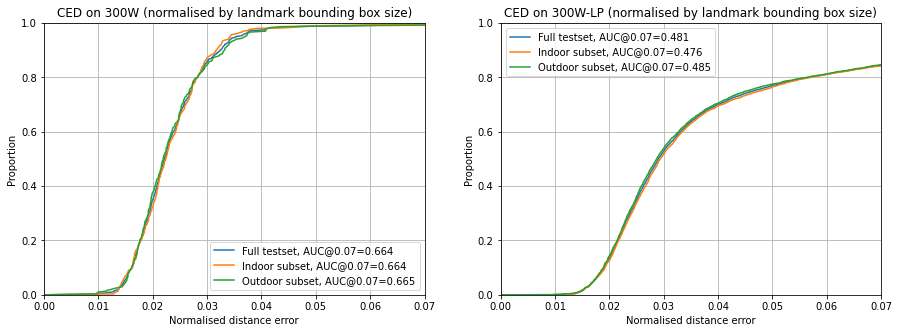

In [12]:
best_snapshot, best_ckpt_path = load_best_snapshot(
    sorted(glob.glob(os.path.join('./checkpoints', 'exp_03_03_*')))[::-1])
print(f"Best weights loaded from {best_ckpt_path} at epoch #{best_snapshot['epoch']:.3f}")

fan = FAN(FAN.create_config(num_modules=2, use_avg_pool=False)).to('cuda:0')
fan.load_state_dict(best_snapshot['model_state_dict'])
del best_snapshot
torch.cuda.empty_cache()

eval_on_300w_n_lp(fan)
del fan
torch.cuda.empty_cache()

## Experiment 4.1: Train FAN2 on 300W-LP for 60 epochs
Try to fully train the model on 300W-LP, also add ISO noise and larger cutout augmentation for better robustness

In [5]:
# Create data loaders
trainset_lp_w_noise = deepcopy(trainset_lp)
trainset_lp_w_noise.content_transform=augs.Compose(
    [augs.Blur(p=0.5), augs.ColorJitter(0.3, 0.3, 0.3, 0,3, p=1.0), augs.ISONoise(p=0.5),
     augs.ImageCompression(quality_lower=30, p=0.5), augs.CoarseDropout(
         min_holes=1, max_holes=8, min_width=0.03125, min_height=0.03125,
         max_width=0.25, max_height=0.25, p=0.5)])
trainset_loader = DataLoader(trainset_lp_w_noise, batch_size=32, shuffle=True, num_workers=32, pin_memory=True)
valset_loader = DataLoader(valset_lp, batch_size=16, shuffle=False, num_workers=32, pin_memory=True)
print('Data loaders created.')

# Create the model
fan = FAN(FAN.create_config(num_modules=2, use_avg_pool=False))
fan = torch.nn.DataParallel(fan).cuda()
print('Network initialised.')

# Create the optimiser
optimiser = torch.optim.RMSprop(fan.parameters(), lr=3e-4, momentum=0.9, weight_decay=0.0)
print('Optimiser created.')

# Create the learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=4, gamma=0.7)
print('LR scheduler created.')

# Train the network
torch.cuda.empty_cache()
with tqdm(desc='Epoch') as pbar1, tqdm(desc='Train batch') as pbar2, tqdm(desc='Validation batch') as pbar3:
    exp_04_01_ckpt_path = train_model(
        fan, optimiser, trainset_loader, valset_loader, 60, './logs', './checkpoints',
        f"exp_04_01_fan2_300w_lp_{datetime.utcnow().strftime('%Y-%m-%d_%H-%M-%S.%f')[:-3]}_utc",
        lr_scheduler=lr_scheduler, val_per_epoch=2, save_top_k=10,
        htm_mse_loss_weight=1.0, lmk_dist_loss_weight=0.01, rank_by='val_weighted_macc',
        train_weight_norm=trainset_loader.dataset.weight_norm,
        pbar_epochs=pbar1, pbar_train_batches=pbar2, pbar_val_batches=pbar3)
del lr_scheduler
del optimiser
del fan
torch.cuda.empty_cache()
print(f"Training finished, checkpoint saved to: {exp_04_01_ckpt_path}")

Data loaders created.


/home/hhj/anaconda3/envs/py37misc/lib/python3.7/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


Network initialised.
Optimiser created.
LR scheduler created.


Epoch: 0it [00:00, ?it/s]

Train batch: 0it [00:00, ?it/s]

Validation batch: 0it [00:00, ?it/s]

Training finished, checkpoint saved to: ./checkpoints/exp_04_01_fan2_300w_lp_2021-11-03_17-37-08.226_utc.ckpt


Checkpoint:   0%|          | 0/5 [00:00<?, ?it/s]

Best weights loaded from ./checkpoints/exp_04_01_fan2_300w_lp_2021-11-03_17-37-08.226_utc.ckpt at epoch #41.500


Test batch (300W indoor): 0it [00:00, ?it/s]

Test batch (300W outdoor): 0it [00:00, ?it/s]

Test batch (300W-LP indoor): 0it [00:00, ?it/s]

Test batch (300W-LP outdoor): 0it [00:00, ?it/s]

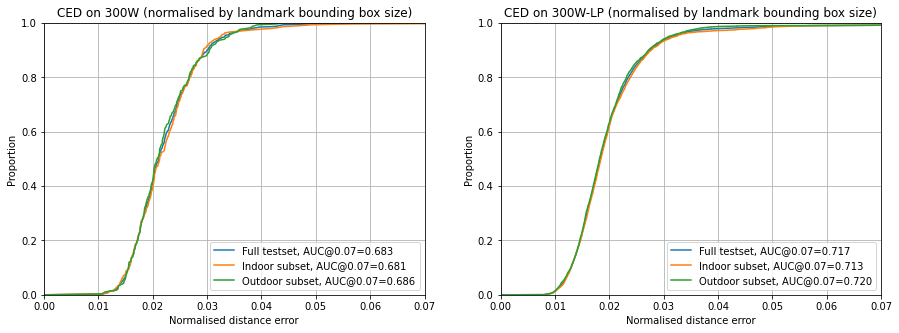

In [6]:
best_snapshot, best_ckpt_path = load_best_snapshot(
    sorted(glob.glob(os.path.join('./checkpoints', 'exp_04_01_*')))[::-1])
print(f"Best weights loaded from {best_ckpt_path} at epoch #{best_snapshot['epoch']:.3f}")

fan = FAN(FAN.create_config(num_modules=2, use_avg_pool=False)).to('cuda:0')
fan.load_state_dict(best_snapshot['model_state_dict'])
del best_snapshot
torch.cuda.empty_cache()

eval_on_300w_n_lp(fan)
del fan
torch.cuda.empty_cache()

## Experiment 4.2: Train FAN2 on 300W-LP for 60 epochs with loss on adversarial examples
And try to fully train the model on 300W-LP, also add ISO noise and larger cutout augmentation for better robustness

In [ ]:
# Create data loaders
trainset_lp_w_noise = deepcopy(trainset_lp)
trainset_lp_w_noise.content_transform=augs.Compose(
    [augs.Blur(p=0.5), augs.ColorJitter(0.3, 0.3, 0.3, 0,3, p=1.0), augs.ISONoise(p=0.5),
     augs.ImageCompression(quality_lower=30, p=0.5), augs.CoarseDropout(
         min_holes=1, max_holes=8, min_width=0.03125, min_height=0.03125,
         max_width=0.25, max_height=0.25, p=0.5)])
trainset_loader = DataLoader(trainset_lp_w_noise, batch_size=32, shuffle=True, num_workers=32, pin_memory=True)
valset_loader = DataLoader(valset_lp, batch_size=16, shuffle=False, num_workers=32, pin_memory=True)
print('Data loaders created.')

# Create the model
fan = FAN(FAN.create_config(num_modules=2, use_avg_pool=False))
fan = torch.nn.DataParallel(fan).cuda()
print('Network initialised.')

# Create the optimiser
optimiser = torch.optim.RMSprop(fan.parameters(), lr=3e-4, momentum=0.9, weight_decay=0.0)
print('Optimiser created.')

# Create the learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=4, gamma=0.7)
print('LR scheduler created.')

# Train the network
torch.cuda.empty_cache()
with tqdm(desc='Epoch') as pbar1, tqdm(desc='Train batch') as pbar2, tqdm(desc='Validation batch') as pbar3:
    exp_04_02_ckpt_path = train_model(
        fan, optimiser, trainset_loader, valset_loader, 60, './logs', './checkpoints',
        f"exp_04_02_fan2_300w_lp_{datetime.utcnow().strftime('%Y-%m-%d_%H-%M-%S.%f')[:-3]}_utc",
        lr_scheduler=lr_scheduler, val_per_epoch=2, save_top_k=10,
        htm_mse_loss_weight=1.0, lmk_dist_loss_weight=0.01, rank_by='val_weighted_macc',
        train_weight_norm=trainset_loader.dataset.weight_norm,
        adv_loss_weight=0.1, pgd_epsilon=0.004, pgd_alpha=0.002, pgd_num_steps=4,
        pbar_epochs=pbar1, pbar_train_batches=pbar2, pbar_val_batches=pbar3)
del lr_scheduler
del optimiser
del fan
torch.cuda.empty_cache()
print(f"Training finished, checkpoint saved to: {exp_04_02_ckpt_path}")

Data loaders created.


/home/hhj/anaconda3/envs/py37misc/lib/python3.7/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


Network initialised.
Optimiser created.
LR scheduler created.


Epoch: 0it [00:00, ?it/s]

Train batch: 0it [00:00, ?it/s]

Validation batch: 0it [00:00, ?it/s]

Checkpoint:   0%|          | 0/2 [00:00<?, ?it/s]

Best weights loaded from ./checkpoints/exp_04_02_fan2_300w_lp_2021-11-20_11-54-42.222_utc.ckpt at epoch #29.000


Test batch (300W indoor): 0it [00:00, ?it/s]

Test batch (300W outdoor): 0it [00:00, ?it/s]

Test batch (300W-LP indoor): 0it [00:00, ?it/s]

Test batch (300W-LP outdoor): 0it [00:00, ?it/s]

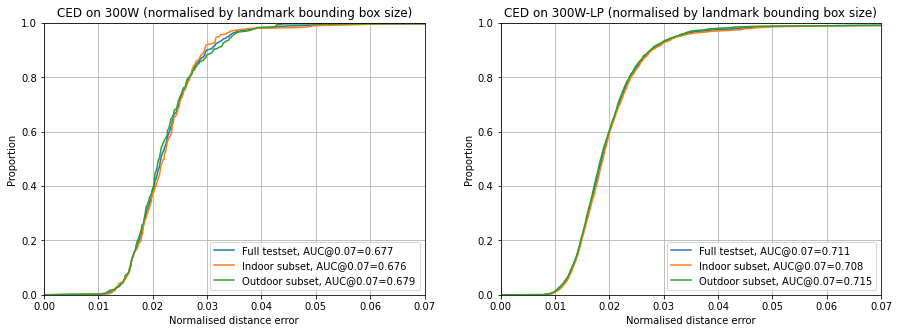

In [8]:
best_snapshot, best_ckpt_path = load_best_snapshot(
    sorted(glob.glob(os.path.join('./checkpoints', 'exp_04_02_*')))[::-1])
print(f"Best weights loaded from {best_ckpt_path} at epoch #{best_snapshot['epoch']:.3f}")

fan = FAN(FAN.create_config(num_modules=2, use_avg_pool=False)).to('cuda:0')
fan.load_state_dict(best_snapshot['model_state_dict'])
del best_snapshot
torch.cuda.empty_cache()

eval_on_300w_n_lp(fan)
del fan
torch.cuda.empty_cache()

## Experiment 4.3: Train FAN2 with instance-norm on 300W-LP for 60 epochs

In [5]:
# Create data loaders
trainset_lp_w_noise = deepcopy(trainset_lp)
trainset_lp_w_noise.content_transform=augs.Compose(
    [augs.Blur(p=0.5), augs.ColorJitter(0.3, 0.3, 0.3, 0,3, p=1.0), augs.ISONoise(p=0.5),
     augs.ImageCompression(quality_lower=30, p=0.5), augs.CoarseDropout(
         min_holes=1, max_holes=8, min_width=0.03125, min_height=0.03125,
         max_width=0.25, max_height=0.25, p=0.5)])
trainset_loader = DataLoader(trainset_lp_w_noise, batch_size=32, shuffle=True, num_workers=32, pin_memory=True)
valset_loader = DataLoader(valset_lp, batch_size=16, shuffle=False, num_workers=32, pin_memory=True)
print('Data loaders created.')

# Create the model
fan = FAN(FAN.create_config(num_modules=2, use_avg_pool=False, use_instance_norm=True))
fan = torch.nn.DataParallel(fan).cuda()
print('Network initialised.')

# Create the optimiser
optimiser = torch.optim.RMSprop(fan.parameters(), lr=3e-4, momentum=0.9, weight_decay=0.0)
print('Optimiser created.')

# Create the learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=4, gamma=0.7)
print('LR scheduler created.')

# Train the network
torch.cuda.empty_cache()
with tqdm(desc='Epoch') as pbar1, tqdm(desc='Train batch') as pbar2, tqdm(desc='Validation batch') as pbar3:
    exp_04_03_ckpt_path = train_model(
        fan, optimiser, trainset_loader, valset_loader, 60, './logs', './checkpoints',
        f"exp_04_03_fan2_300w_lp_{datetime.utcnow().strftime('%Y-%m-%d_%H-%M-%S.%f')[:-3]}_utc",
        lr_scheduler=lr_scheduler, val_per_epoch=2, save_top_k=10,
        htm_mse_loss_weight=1.0, lmk_dist_loss_weight=0.01, rank_by='val_weighted_macc',
        train_weight_norm=trainset_loader.dataset.weight_norm,
        pbar_epochs=pbar1, pbar_train_batches=pbar2, pbar_val_batches=pbar3)
del lr_scheduler
del optimiser
del fan
torch.cuda.empty_cache()
print(f"Training finished, checkpoint saved to: {exp_04_03_ckpt_path}")

Data loaders created.


/home/hhj/anaconda3/envs/py37misc/lib/python3.7/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


Network initialised.
Optimiser created.
LR scheduler created.


Epoch: 0it [00:00, ?it/s]

Train batch: 0it [00:00, ?it/s]

Validation batch: 0it [00:00, ?it/s]

Training finished, checkpoint saved to: ./checkpoints/exp_04_03_fan2_300w_lp_2021-12-17_14-43-57.594_utc.ckpt


Checkpoint:   0%|          | 0/1 [00:00<?, ?it/s]

Best weights loaded from ./checkpoints/exp_04_03_fan2_300w_lp_2021-12-17_14-43-57.594_utc.ckpt at epoch #41.500


Test batch (300W indoor): 0it [00:00, ?it/s]

Test batch (300W outdoor): 0it [00:00, ?it/s]

Test batch (300W-LP indoor): 0it [00:00, ?it/s]

Test batch (300W-LP outdoor): 0it [00:00, ?it/s]

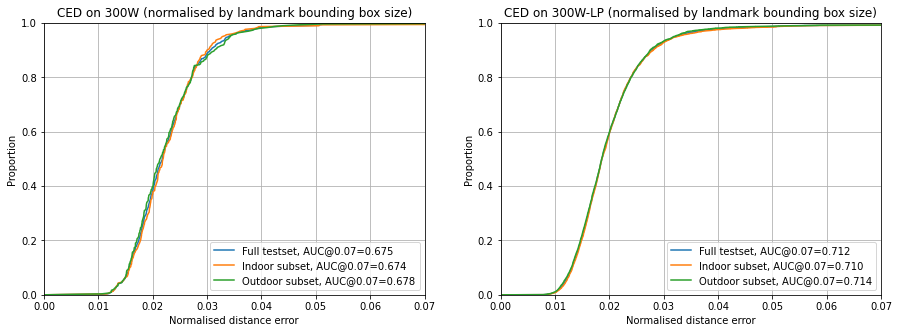

In [7]:
best_snapshot, best_ckpt_path = load_best_snapshot(
    sorted(glob.glob(os.path.join('./checkpoints', 'exp_04_03_*')))[::-1])
print(f"Best weights loaded from {best_ckpt_path} at epoch #{best_snapshot['epoch']:.3f}")

fan = FAN(FAN.create_config(num_modules=2, use_avg_pool=False, use_instance_norm=True)).to('cuda:0')
fan.load_state_dict(best_snapshot['model_state_dict'])
del best_snapshot
torch.cuda.empty_cache()

eval_on_300w_n_lp(fan)
del fan
torch.cuda.empty_cache()

## Experiment 4.4: Train FAN2 with half-sized everything on 300W-LP for 60 epochs

In [6]:
# Create data loaders
trainset_lp_small_w_noise = deepcopy(trainset_lp_small)
trainset_lp_small_w_noise.content_transform=augs.Compose(
    [augs.Blur(p=0.5), augs.ColorJitter(0.3, 0.3, 0.3, 0,3, p=1.0), augs.ISONoise(p=0.5),
     augs.ImageCompression(quality_lower=30, p=0.5), augs.CoarseDropout(
         min_holes=1, max_holes=8, min_width=0.03125, min_height=0.03125,
         max_width=0.25, max_height=0.25, p=0.5)])
trainset_loader = DataLoader(trainset_lp_small_w_noise, batch_size=32, shuffle=True, num_workers=32, pin_memory=True)
valset_loader = DataLoader(valset_lp_small, batch_size=16, shuffle=False, num_workers=32, pin_memory=True)
print('Data loaders created.')

# Create the model
fan = FAN(FAN.create_config(num_modules=2, use_avg_pool=False, input_size=128))
fan = torch.nn.DataParallel(fan).cuda()
print('Network initialised.')

# Create the optimiser
optimiser = torch.optim.RMSprop(fan.parameters(), lr=3e-4, momentum=0.9, weight_decay=0.0)
print('Optimiser created.')

# Create the learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=4, gamma=0.7)
print('LR scheduler created.')

# Train the network
torch.cuda.empty_cache()
with tqdm(desc='Epoch') as pbar1, tqdm(desc='Train batch') as pbar2, tqdm(desc='Validation batch') as pbar3:
    exp_04_04_ckpt_path = train_model(
        fan, optimiser, trainset_loader, valset_loader, 60, './logs', './checkpoints',
        f"exp_04_04_fan2_300w_lp_{datetime.utcnow().strftime('%Y-%m-%d_%H-%M-%S.%f')[:-3]}_utc",
        lr_scheduler=lr_scheduler, val_per_epoch=2, save_top_k=10,
        htm_mse_loss_weight=1.0, lmk_dist_loss_weight=0.01, rank_by='val_weighted_macc',
        train_weight_norm=trainset_loader.dataset.weight_norm,
        pbar_epochs=pbar1, pbar_train_batches=pbar2, pbar_val_batches=pbar3)
del lr_scheduler
del optimiser
del fan
torch.cuda.empty_cache()
print(f"Training finished, checkpoint saved to: {exp_04_04_ckpt_path}")

Data loaders created.
Network initialised.
Optimiser created.
LR scheduler created.


/home/hhj/anaconda3/envs/py37misc/lib/python3.7/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


Epoch: 0it [00:00, ?it/s]

Train batch: 0it [00:00, ?it/s]

Validation batch: 0it [00:00, ?it/s]

Training finished, checkpoint saved to: ./checkpoints/exp_04_04_fan2_300w_lp_2022-01-21_12-00-03.108_utc.ckpt


Checkpoint:   0%|          | 0/1 [00:00<?, ?it/s]

Best weights loaded from ./checkpoints/exp_04_04_fan2_300w_lp_2022-01-21_12-00-03.108_utc.ckpt at epoch #17.000


Test batch (300W indoor): 0it [00:00, ?it/s]

Test batch (300W outdoor): 0it [00:00, ?it/s]

Test batch (300W-LP indoor): 0it [00:00, ?it/s]

Test batch (300W-LP outdoor): 0it [00:00, ?it/s]

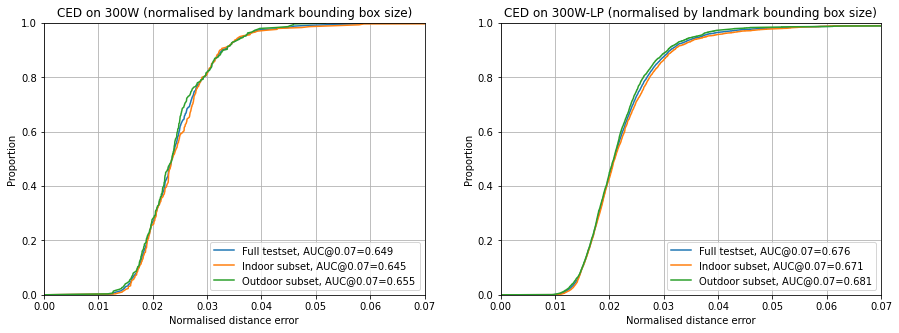

In [6]:
best_snapshot, best_ckpt_path = load_best_snapshot(
    sorted(glob.glob(os.path.join('./checkpoints', 'exp_04_04_*')))[::-1])
print(f"Best weights loaded from {best_ckpt_path} at epoch #{best_snapshot['epoch']:.3f}")

fan = FAN(FAN.create_config(num_modules=2, use_avg_pool=False, input_size=128)).to('cuda:0')
fan.load_state_dict(best_snapshot['model_state_dict'])
del best_snapshot
torch.cuda.empty_cache()

eval_on_300w_n_lp_small(fan)
del fan
torch.cuda.empty_cache()

## Experiment 4.5: Train FAN2 with half-sized input on 300W-LP for 60 epochs (alt)

In [5]:
# Create data loaders
trainset_lp_small2_w_noise = deepcopy(trainset_lp_small2)
trainset_lp_small2_w_noise.content_transform=augs.Compose(
    [augs.Blur(p=0.5), augs.ColorJitter(0.3, 0.3, 0.3, 0,3, p=1.0), augs.ISONoise(p=0.5),
     augs.ImageCompression(quality_lower=30, p=0.5), augs.CoarseDropout(
         min_holes=1, max_holes=8, min_width=0.03125, min_height=0.03125,
         max_width=0.25, max_height=0.25, p=0.5)])
trainset_loader = DataLoader(trainset_lp_small2_w_noise, batch_size=32, shuffle=True, num_workers=32, pin_memory=True)
valset_loader = DataLoader(valset_lp_small2, batch_size=16, shuffle=False, num_workers=32, pin_memory=True)
print('Data loaders created.')

# Create the model
fan = FAN(FAN.create_config(num_modules=2, use_avg_pool=False, input_size=128, stem_pool_kernel_size=1))
fan = torch.nn.DataParallel(fan).cuda()
print('Network initialised.')

# Create the optimiser
optimiser = torch.optim.RMSprop(fan.parameters(), lr=3e-4, momentum=0.9, weight_decay=0.0)
print('Optimiser created.')

# Create the learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=4, gamma=0.7)
print('LR scheduler created.')

# Train the network
torch.cuda.empty_cache()
with tqdm(desc='Epoch') as pbar1, tqdm(desc='Train batch') as pbar2, tqdm(desc='Validation batch') as pbar3:
    exp_04_05_ckpt_path = train_model(
        fan, optimiser, trainset_loader, valset_loader, 60, './logs', './checkpoints',
        f"exp_04_05_fan2_300w_lp_{datetime.utcnow().strftime('%Y-%m-%d_%H-%M-%S.%f')[:-3]}_utc",
        lr_scheduler=lr_scheduler, val_per_epoch=2, save_top_k=10,
        htm_mse_loss_weight=1.0, lmk_dist_loss_weight=0.01, rank_by='val_weighted_macc',
        train_weight_norm=trainset_loader.dataset.weight_norm,
        pbar_epochs=pbar1, pbar_train_batches=pbar2, pbar_val_batches=pbar3)
del lr_scheduler
del optimiser
del fan
torch.cuda.empty_cache()
print(f"Training finished, checkpoint saved to: {exp_04_05_ckpt_path}")

Data loaders created.


/home/hhj/anaconda3/envs/py37misc/lib/python3.7/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


Network initialised.
Optimiser created.
LR scheduler created.


Epoch: 0it [00:00, ?it/s]

Train batch: 0it [00:00, ?it/s]

Validation batch: 0it [00:00, ?it/s]

Training finished, checkpoint saved to: ./checkpoints/exp_04_05_fan2_300w_lp_2022-01-24_00-33-04.167_utc.ckpt


Checkpoint:   0%|          | 0/1 [00:00<?, ?it/s]

Best weights loaded from ./checkpoints/exp_04_05_fan2_300w_lp_2022-01-24_00-33-04.167_utc.ckpt at epoch #53.000


Test batch (300W indoor): 0it [00:00, ?it/s]

Test batch (300W outdoor): 0it [00:00, ?it/s]

Test batch (300W-LP indoor): 0it [00:00, ?it/s]

Test batch (300W-LP outdoor): 0it [00:00, ?it/s]

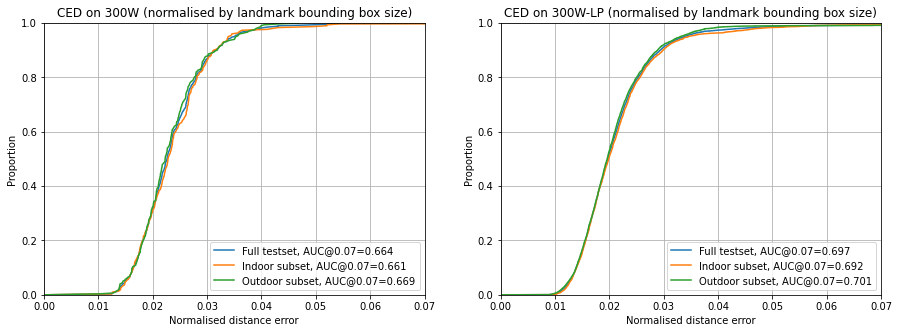

In [6]:
best_snapshot, best_ckpt_path = load_best_snapshot(
    sorted(glob.glob(os.path.join('./checkpoints', 'exp_04_05_*')))[::-1])
print(f"Best weights loaded from {best_ckpt_path} at epoch #{best_snapshot['epoch']:.3f}")

fan = FAN(FAN.create_config(num_modules=2, use_avg_pool=False, input_size=128, stem_pool_kernel_size=1)).to('cuda:0')
fan.load_state_dict(best_snapshot['model_state_dict'])
del best_snapshot
torch.cuda.empty_cache()

eval_on_300w_n_lp_small2(fan)
del fan
torch.cuda.empty_cache()

## Experiment 5.1: Train FAN2 with loss on adversarial exampless on 300W for 60 epochs

In [5]:
# Create data loaders
trainset_loader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=32, pin_memory=True)
valset_loader = DataLoader(valset, batch_size=16, shuffle=False, num_workers=32, pin_memory=True)
print('Data loaders created.')

# Create the model
fan = FAN(FAN.create_config(num_modules=2, use_avg_pool=False))
fan = torch.nn.DataParallel(fan).cuda()
print('Network initialised.')

# Create the optimiser
optimiser = torch.optim.RMSprop(fan.parameters(), lr=5e-4, momentum=0.9, weight_decay=0.0)
print('Optimiser created.')

# Create the learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=8, gamma=0.7)
print('LR scheduler created.')

# Train the network
torch.cuda.empty_cache()
with tqdm(desc='Epoch') as pbar1, tqdm(desc='Train batch') as pbar2, tqdm(desc='Validation batch') as pbar3:
    exp_05_01_ckpt_path = train_model(
        fan, optimiser, trainset_loader, valset_loader, 60, './logs', './checkpoints',
        f"exp_05_01_fan2_300w_{datetime.utcnow().strftime('%Y-%m-%d_%H-%M-%S.%f')[:-3]}_utc",
        lr_scheduler=lr_scheduler, val_per_epoch=2, save_top_k=10,
        htm_mse_loss_weight=1.0, lmk_dist_loss_weight=0.01, rank_by='val_weighted_macc',
        train_weight_norm=trainset_loader.dataset.weight_norm,
        adv_loss_weight=0.1, pgd_epsilon=0.004, pgd_alpha=0.002, pgd_num_steps=4,
        pbar_epochs=pbar1, pbar_train_batches=pbar2, pbar_val_batches=pbar3)
del lr_scheduler
del optimiser
del fan
torch.cuda.empty_cache()
print(f"Training finished, checkpoint saved to: {exp_05_01_ckpt_path}")

Data loaders created.


/home/hhj/anaconda3/envs/py37misc/lib/python3.7/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


Network initialised.
Optimiser created.
LR scheduler created.


Epoch: 0it [00:00, ?it/s]

Train batch: 0it [00:00, ?it/s]

Validation batch: 0it [00:00, ?it/s]

Training finished, checkpoint saved to: ./checkpoints/exp_05_01_fan2_300w_2021-11-19_10-08-56.497_utc.ckpt


Checkpoint:   0%|          | 0/14 [00:00<?, ?it/s]

Best weights loaded from ./checkpoints/exp_05_01_fan2_300w_2021-11-18_22-07-26.523_utc.ckpt at epoch #47.000


Test batch (300W indoor): 0it [00:00, ?it/s]

Test batch (300W outdoor): 0it [00:00, ?it/s]

Test batch (300W-LP indoor): 0it [00:00, ?it/s]

Test batch (300W-LP outdoor): 0it [00:00, ?it/s]

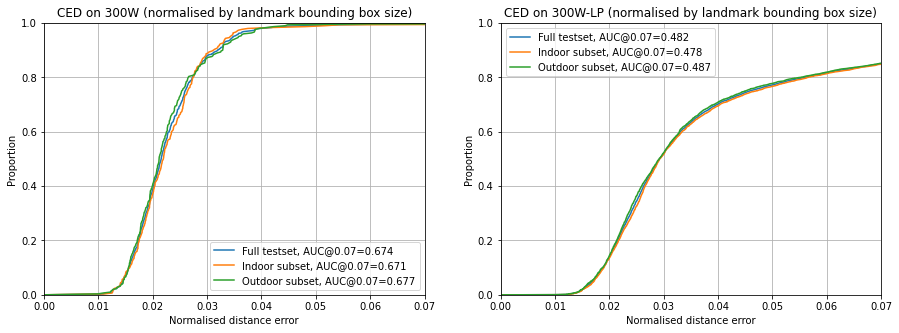

In [10]:
best_snapshot, best_ckpt_path = load_best_snapshot(
    sorted(glob.glob(os.path.join('./checkpoints', 'exp_05_01_*')))[::-1])
print(f"Best weights loaded from {best_ckpt_path} at epoch #{best_snapshot['epoch']:.3f}")

fan = FAN(FAN.create_config(num_modules=2, use_avg_pool=False)).to('cuda:0')
fan.load_state_dict(best_snapshot['model_state_dict'])
del best_snapshot
torch.cuda.empty_cache()

eval_on_300w_n_lp(fan)
del fan
torch.cuda.empty_cache()

## Experiment 6.1: Train FAN2 with instance-norm on 300W for 60 epochs

In [5]:
# Create data loaders
trainset_loader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=32, pin_memory=True)
valset_loader = DataLoader(valset, batch_size=16, shuffle=False, num_workers=32, pin_memory=True)
print('Data loaders created.')

# Create the model
fan = FAN(FAN.create_config(num_modules=2, use_avg_pool=False, use_instance_norm=True))
fan = torch.nn.DataParallel(fan).cuda()
print('Network initialised.')

# Create the optimiser
optimiser = torch.optim.RMSprop(fan.parameters(), lr=5e-4, momentum=0.9, weight_decay=0.0)
print('Optimiser created.')

# Create the learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=8, gamma=0.7)
print('LR scheduler created.')

# Train the network
torch.cuda.empty_cache()
with tqdm(desc='Epoch') as pbar1, tqdm(desc='Train batch') as pbar2, tqdm(desc='Validation batch') as pbar3:
    exp_06_01_ckpt_path = train_model(
        fan, optimiser, trainset_loader, valset_loader, 60, './logs', './checkpoints',
        f"exp_06_01_fan2_300w_{datetime.utcnow().strftime('%Y-%m-%d_%H-%M-%S.%f')[:-3]}_utc",
        lr_scheduler=lr_scheduler, val_per_epoch=2, save_top_k=10,
        htm_mse_loss_weight=1.0, lmk_dist_loss_weight=0.01, rank_by='val_weighted_macc',
        train_weight_norm=trainset_loader.dataset.weight_norm,
        pbar_epochs=pbar1, pbar_train_batches=pbar2, pbar_val_batches=pbar3)
del lr_scheduler
del optimiser
del fan
torch.cuda.empty_cache()
print(f"Training finished, checkpoint saved to: {exp_06_01_ckpt_path}")

Data loaders created.


/home/hhj/anaconda3/envs/py37misc/lib/python3.7/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


Network initialised.
Optimiser created.
LR scheduler created.


Epoch: 0it [00:00, ?it/s]

Train batch: 0it [00:00, ?it/s]

Validation batch: 0it [00:00, ?it/s]

Training finished, checkpoint saved to: ./checkpoints/exp_06_01_fan2_300w_2021-12-17_11-05-36.586_utc.ckpt


Checkpoint:   0%|          | 0/2 [00:00<?, ?it/s]

Best weights loaded from ./checkpoints/exp_06_01_fan2_300w_2021-12-17_11-05-36.586_utc.ckpt at epoch #57.502


Test batch (300W indoor): 0it [00:00, ?it/s]

Test batch (300W outdoor): 0it [00:00, ?it/s]

Test batch (300W-LP indoor): 0it [00:00, ?it/s]

Test batch (300W-LP outdoor): 0it [00:00, ?it/s]

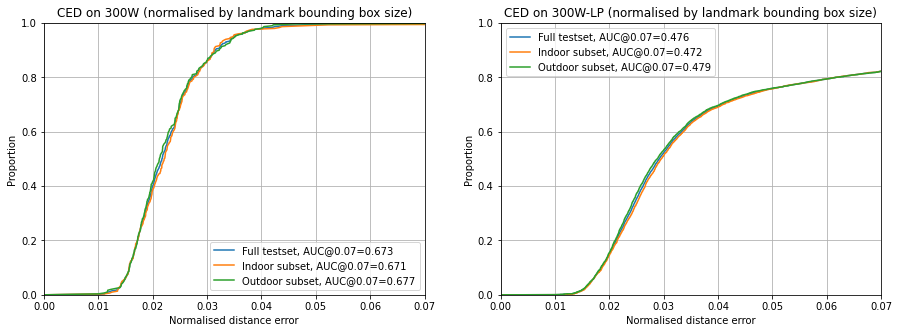

In [7]:
best_snapshot, best_ckpt_path = load_best_snapshot(
    sorted(glob.glob(os.path.join('./checkpoints', 'exp_06_01_*')))[::-1])
print(f"Best weights loaded from {best_ckpt_path} at epoch #{best_snapshot['epoch']:.3f}")

fan = FAN(FAN.create_config(num_modules=2, use_avg_pool=False, use_instance_norm=True)).to('cuda:0')
fan.load_state_dict(best_snapshot['model_state_dict'])
del best_snapshot
torch.cuda.empty_cache()

eval_on_300w_n_lp(fan)
del fan
torch.cuda.empty_cache()

## Experiment 7.1: Train FAN2 with half-sized everything on 300W for 60 epochs

In [5]:
# Create data loaders
trainset_loader = DataLoader(trainset_small, batch_size=32, shuffle=True, num_workers=32, pin_memory=True)
valset_loader = DataLoader(valset_small, batch_size=16, shuffle=False, num_workers=32, pin_memory=True)
print('Data loaders created.')

# Create the model
fan = FAN(FAN.create_config(num_modules=2, use_avg_pool=False, input_size=128))
fan = torch.nn.DataParallel(fan).cuda()
print('Network initialised.')

# Create the optimiser
optimiser = torch.optim.RMSprop(fan.parameters(), lr=5e-4, momentum=0.9, weight_decay=0.0)
print('Optimiser created.')

# Create the learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=8, gamma=0.7)
print('LR scheduler created.')

# Train the network
torch.cuda.empty_cache()
with tqdm(desc='Epoch') as pbar1, tqdm(desc='Train batch') as pbar2, tqdm(desc='Validation batch') as pbar3:
    exp_07_01_ckpt_path = train_model(
        fan, optimiser, trainset_loader, valset_loader, 60, './logs', './checkpoints',
        f"exp_07_01_fan2_300w_{datetime.utcnow().strftime('%Y-%m-%d_%H-%M-%S.%f')[:-3]}_utc",
        lr_scheduler=lr_scheduler, val_per_epoch=2, save_top_k=10,
        htm_mse_loss_weight=1.0, lmk_dist_loss_weight=0.01, rank_by='val_weighted_macc',
        train_weight_norm=trainset_loader.dataset.weight_norm,
        pbar_epochs=pbar1, pbar_train_batches=pbar2, pbar_val_batches=pbar3)
del lr_scheduler
del optimiser
del fan
torch.cuda.empty_cache()
print(f"Training finished, checkpoint saved to: {exp_07_01_ckpt_path}")

Data loaders created.


/home/hhj/anaconda3/envs/py37misc/lib/python3.7/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


Network initialised.
Optimiser created.
LR scheduler created.


Epoch: 0it [00:00, ?it/s]

Train batch: 0it [00:00, ?it/s]

Validation batch: 0it [00:00, ?it/s]

Training finished, checkpoint saved to: ./checkpoints/exp_07_01_fan2_300w_2022-01-20_23-53-58.287_utc.ckpt


Checkpoint:   0%|          | 0/1 [00:00<?, ?it/s]

Best weights loaded from ./checkpoints/exp_07_01_fan2_300w_2022-01-20_23-53-58.287_utc.ckpt at epoch #55.000


Test batch (300W indoor): 0it [00:00, ?it/s]

Test batch (300W outdoor): 0it [00:00, ?it/s]

Test batch (300W-LP indoor): 0it [00:00, ?it/s]

Test batch (300W-LP outdoor): 0it [00:00, ?it/s]

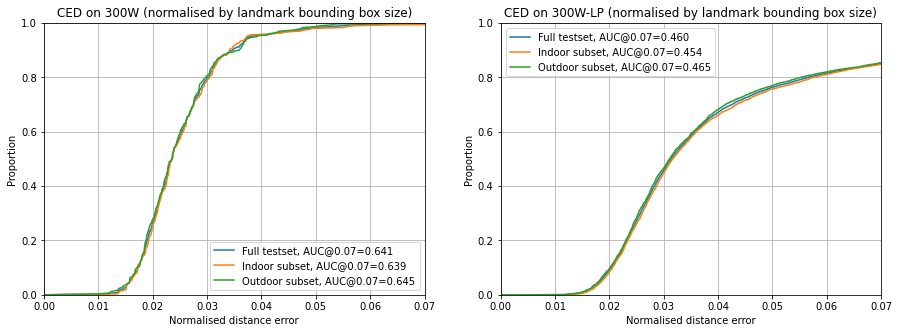

In [5]:
best_snapshot, best_ckpt_path = load_best_snapshot(
    sorted(glob.glob(os.path.join('./checkpoints', 'exp_07_01_*')))[::-1])
print(f"Best weights loaded from {best_ckpt_path} at epoch #{best_snapshot['epoch']:.3f}")

fan = FAN(FAN.create_config(num_modules=2, use_avg_pool=False, input_size=128)).to('cuda:0')
fan.load_state_dict(best_snapshot['model_state_dict'])
del best_snapshot
torch.cuda.empty_cache()

eval_on_300w_n_lp_small(fan)
del fan
torch.cuda.empty_cache()

## Experiment 7.2: Train FAN2 with half-sized input on 300W for 60 epochs

In [5]:
# Create data loaders
trainset_loader = DataLoader(trainset_small2, batch_size=32, shuffle=True, num_workers=32, pin_memory=True)
valset_loader = DataLoader(valset_small2, batch_size=16, shuffle=False, num_workers=32, pin_memory=True)
print('Data loaders created.')

# # Create the model
fan = FAN(FAN.create_config(num_modules=2, use_avg_pool=False, input_size=128, stem_conv_stride=1))
fan = torch.nn.DataParallel(fan).cuda()
print('Network initialised.')

# Create the optimiser
optimiser = torch.optim.RMSprop(fan.parameters(), lr=5e-4, momentum=0.9, weight_decay=0.0)
print('Optimiser created.')

# Create the learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=8, gamma=0.7)
print('LR scheduler created.')

# Train the network
torch.cuda.empty_cache()
with tqdm(desc='Epoch') as pbar1, tqdm(desc='Train batch') as pbar2, tqdm(desc='Validation batch') as pbar3:
    exp_07_02_ckpt_path = train_model(
        fan, optimiser, trainset_loader, valset_loader, 60, './logs', './checkpoints',
        f"exp_07_02_fan2_300w_{datetime.utcnow().strftime('%Y-%m-%d_%H-%M-%S.%f')[:-3]}_utc",
        lr_scheduler=lr_scheduler, val_per_epoch=2, save_top_k=10,
        htm_mse_loss_weight=1.0, lmk_dist_loss_weight=0.01, rank_by='val_weighted_macc',
        train_weight_norm=trainset_loader.dataset.weight_norm,
        pbar_epochs=pbar1, pbar_train_batches=pbar2, pbar_val_batches=pbar3)
del lr_scheduler
del optimiser
del fan
torch.cuda.empty_cache()
print(f"Training finished, checkpoint saved to: {exp_07_02_ckpt_path}")

Data loaders created.


/home/hhj/anaconda3/envs/py37misc/lib/python3.7/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


Network initialised.
Optimiser created.
LR scheduler created.


Epoch: 0it [00:00, ?it/s]

Train batch: 0it [00:00, ?it/s]

Validation batch: 0it [00:00, ?it/s]

Training finished, checkpoint saved to: ./checkpoints/exp_07_02_fan2_300w_2022-01-23_19-34-37.081_utc.ckpt


Checkpoint:   0%|          | 0/2 [00:00<?, ?it/s]

Best weights loaded from ./checkpoints/exp_07_02_fan2_300w_2022-01-23_19-34-37.081_utc.ckpt at epoch #54.502


Test batch (300W indoor): 0it [00:00, ?it/s]

Test batch (300W outdoor): 0it [00:00, ?it/s]

Test batch (300W-LP indoor): 0it [00:00, ?it/s]

Test batch (300W-LP outdoor): 0it [00:00, ?it/s]

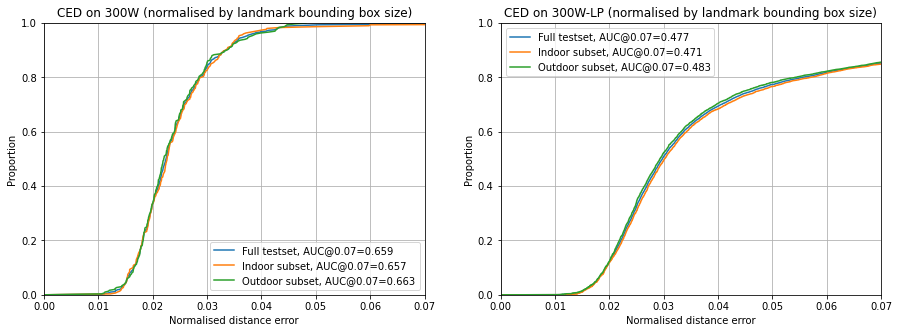

In [7]:
best_snapshot, best_ckpt_path = load_best_snapshot(
    sorted(glob.glob(os.path.join('./checkpoints', 'exp_07_02_*')))[::-1])
print(f"Best weights loaded from {best_ckpt_path} at epoch #{best_snapshot['epoch']:.3f}")

fan = FAN(FAN.create_config(num_modules=2, use_avg_pool=False, input_size=128, stem_conv_stride=1)).to('cuda:0')
fan.load_state_dict(best_snapshot['model_state_dict'])
del best_snapshot
torch.cuda.empty_cache()

eval_on_300w_n_lp_small2(fan)
del fan
torch.cuda.empty_cache()

## Experiment 7.3: Train FAN2 with half-sized input on 300W for 60 epochs (alt)

In [8]:
# Create data loaders
trainset_loader = DataLoader(trainset_small2, batch_size=32, shuffle=True, num_workers=32, pin_memory=True)
valset_loader = DataLoader(valset_small2, batch_size=16, shuffle=False, num_workers=32, pin_memory=True)
print('Data loaders created.')

# # Create the model
fan = FAN(FAN.create_config(num_modules=2, use_avg_pool=False, input_size=128, stem_pool_kernel_size=1))
fan = torch.nn.DataParallel(fan).cuda()
print('Network initialised.')

# Create the optimiser
optimiser = torch.optim.RMSprop(fan.parameters(), lr=5e-4, momentum=0.9, weight_decay=0.0)
print('Optimiser created.')

# Create the learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=8, gamma=0.7)
print('LR scheduler created.')

# Train the network
torch.cuda.empty_cache()
with tqdm(desc='Epoch') as pbar1, tqdm(desc='Train batch') as pbar2, tqdm(desc='Validation batch') as pbar3:
    exp_07_03_ckpt_path = train_model(
        fan, optimiser, trainset_loader, valset_loader, 60, './logs', './checkpoints',
        f"exp_07_03_fan2_300w_{datetime.utcnow().strftime('%Y-%m-%d_%H-%M-%S.%f')[:-3]}_utc",
        lr_scheduler=lr_scheduler, val_per_epoch=2, save_top_k=10,
        htm_mse_loss_weight=1.0, lmk_dist_loss_weight=0.01, rank_by='val_weighted_macc',
        train_weight_norm=trainset_loader.dataset.weight_norm,
        pbar_epochs=pbar1, pbar_train_batches=pbar2, pbar_val_batches=pbar3)
del lr_scheduler
del optimiser
del fan
torch.cuda.empty_cache()
print(f"Training finished, checkpoint saved to: {exp_07_03_ckpt_path}")

Data loaders created.
Network initialised.
Optimiser created.
LR scheduler created.


/home/hhj/anaconda3/envs/py37misc/lib/python3.7/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


Epoch: 0it [00:00, ?it/s]

Train batch: 0it [00:00, ?it/s]

Validation batch: 0it [00:00, ?it/s]

Training finished, checkpoint saved to: ./checkpoints/exp_07_03_fan2_300w_2022-01-23_21-56-29.578_utc.ckpt


Checkpoint:   0%|          | 0/1 [00:00<?, ?it/s]

Best weights loaded from ./checkpoints/exp_07_03_fan2_300w_2022-01-23_21-56-29.578_utc.ckpt at epoch #58.502


Test batch (300W indoor): 0it [00:00, ?it/s]

Test batch (300W outdoor): 0it [00:00, ?it/s]

Test batch (300W-LP indoor): 0it [00:00, ?it/s]

Test batch (300W-LP outdoor): 0it [00:00, ?it/s]

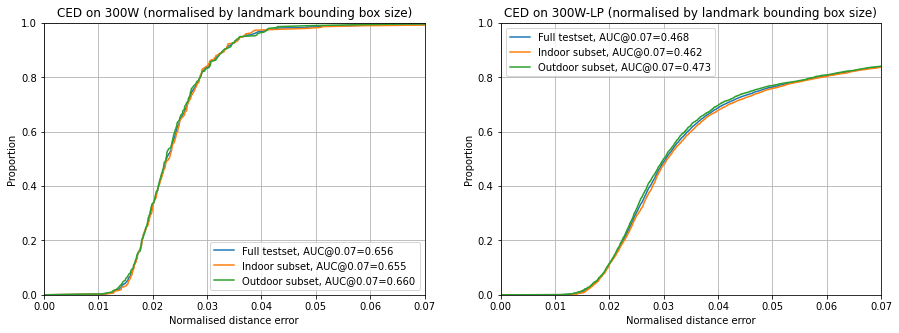

In [9]:
best_snapshot, best_ckpt_path = load_best_snapshot(
    sorted(glob.glob(os.path.join('./checkpoints', 'exp_07_03_*')))[::-1])
print(f"Best weights loaded from {best_ckpt_path} at epoch #{best_snapshot['epoch']:.3f}")

fan = FAN(FAN.create_config(num_modules=2, use_avg_pool=False, input_size=128, stem_pool_kernel_size=1)).to('cuda:0')
fan.load_state_dict(best_snapshot['model_state_dict'])
del best_snapshot
torch.cuda.empty_cache()

eval_on_300w_n_lp_small2(fan)
del fan
torch.cuda.empty_cache()

## Experiment 7.4: Train FAN2 with half-sized input on 300W for 60 epochs (alt2)

In [6]:
# Create data loaders
trainset_loader = DataLoader(trainset_small2, batch_size=32, shuffle=True, num_workers=32, pin_memory=True)
valset_loader = DataLoader(valset_small2, batch_size=16, shuffle=False, num_workers=32, pin_memory=True)
print('Data loaders created.')

# # Create the model
fan = FAN(FAN.create_config(num_modules=2, use_avg_pool=False, input_size=128,
                            stem_conv_kernel_size=5, stem_pool_kernel_size=1))
fan = torch.nn.DataParallel(fan).cuda()
print('Network initialised.')

# Create the optimiser
optimiser = torch.optim.RMSprop(fan.parameters(), lr=5e-4, momentum=0.9, weight_decay=0.0)
print('Optimiser created.')

# Create the learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=8, gamma=0.7)
print('LR scheduler created.')

# Train the network
torch.cuda.empty_cache()
with tqdm(desc='Epoch') as pbar1, tqdm(desc='Train batch') as pbar2, tqdm(desc='Validation batch') as pbar3:
    exp_07_04_ckpt_path = train_model(
        fan, optimiser, trainset_loader, valset_loader, 60, './logs', './checkpoints',
        f"exp_07_04_fan2_300w_{datetime.utcnow().strftime('%Y-%m-%d_%H-%M-%S.%f')[:-3]}_utc",
        lr_scheduler=lr_scheduler, val_per_epoch=2, save_top_k=10,
        htm_mse_loss_weight=1.0, lmk_dist_loss_weight=0.01, rank_by='val_weighted_macc',
        train_weight_norm=trainset_loader.dataset.weight_norm,
        pbar_epochs=pbar1, pbar_train_batches=pbar2, pbar_val_batches=pbar3)
del lr_scheduler
del optimiser
del fan
torch.cuda.empty_cache()
print(f"Training finished, checkpoint saved to: {exp_07_04_ckpt_path}")

Data loaders created.


/home/hhj/anaconda3/envs/py37misc/lib/python3.7/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


Network initialised.
Optimiser created.
LR scheduler created.


Epoch: 0it [00:00, ?it/s]

Train batch: 0it [00:00, ?it/s]

Validation batch: 0it [00:00, ?it/s]

Training finished, checkpoint saved to: ./checkpoints/exp_07_04_fan2_300w_2022-02-09_21-26-04.207_utc.ckpt


Checkpoint:   0%|          | 0/1 [00:00<?, ?it/s]

Best weights loaded from ./checkpoints/exp_07_04_fan2_300w_2022-02-09_21-26-04.207_utc.ckpt at epoch #51.502


Test batch (300W indoor): 0it [00:00, ?it/s]

Test batch (300W outdoor): 0it [00:00, ?it/s]

Test batch (300W-LP indoor): 0it [00:00, ?it/s]

Test batch (300W-LP outdoor): 0it [00:00, ?it/s]

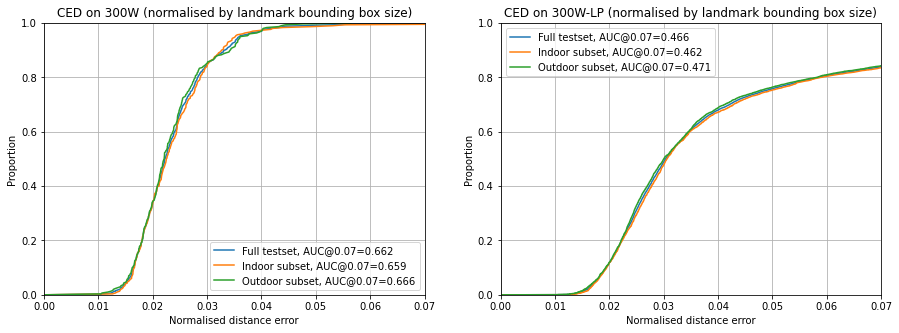

In [7]:
best_snapshot, best_ckpt_path = load_best_snapshot(
    sorted(glob.glob(os.path.join('./checkpoints', 'exp_07_04_*')))[::-1])
print(f"Best weights loaded from {best_ckpt_path} at epoch #{best_snapshot['epoch']:.3f}")

fan = FAN(FAN.create_config(num_modules=2, use_avg_pool=False, input_size=128,
                            stem_conv_kernel_size=5, stem_pool_kernel_size=1)).to('cuda:0')
fan.load_state_dict(best_snapshot['model_state_dict'])
del best_snapshot
torch.cuda.empty_cache()

eval_on_300w_n_lp_small2(fan)
del fan
torch.cuda.empty_cache()